# Updated Code:

1. Calculate Orientation in ELVES and SAGA surveys

2. Load TNG100-1 Data (using 3 satellite lower mass limits)

3. Calculate one- and two-sample KS test for number count in both ELVES/SAGA and TNG100

4. Fit ELVES/SAGA and TNG100 with cosine function, boostrap sample, plot quench fraction

5. Compare sinusoidal function with constant (mean quench fraction) using BIC and AIC statistic



In [1]:
# import libraries, set font, ect.

import matplotlib.pyplot as plt 
%matplotlib inline 

import astropy as ap
from astropy import units as u
from fractions import Fraction 
import astroquery as aq
import numpy as np
from astropy.table import Table
import array as arr
import pandas as pd
import scipy.stats
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
from astropy.table import Table, join

import scipy.interpolate as interp
import scipy
import emcee
import corner
import sys

import matplotlib as mpl

mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"], 
    "mathtext.fontset": "cm",  
    "axes.unicode_minus": False
})


## True Angle versus Projected Angle

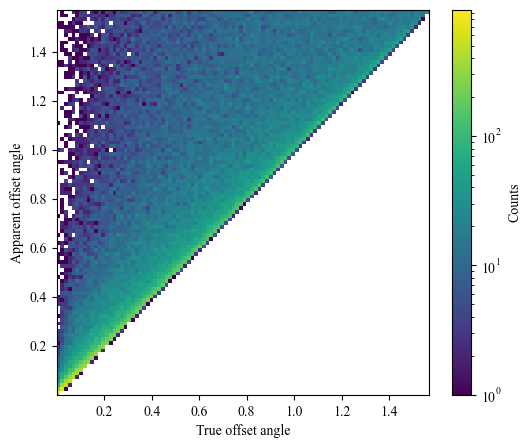

In [2]:
N = 100000
R = 1.0

phi = 2 * np.pi * np.random.random(N)
costheta = 2 * np.random.random(N) - 1
u = np.random.random(N)

theta = np.arccos(costheta)
r = R * u**(1/3)

x = r * np.sin(theta) * np.cos(phi)
y = r * np.sin(theta) * np.sin(phi)
z = r * np.cos(theta)

true_offset_angle = np.arctan(np.abs(z)/np.sqrt(x**2 + y**2))
apparent_offset_angle = np.arctan(np.abs(z)/np.abs(x))

#plt.scatter(true_offset_angle,apparent_offset_angle,alpha=0.005);

plt.figure(figsize=(6, 5))
plt.hist2d(true_offset_angle,apparent_offset_angle,bins=100,norm=mpl.colors.LogNorm())
plt.xlabel('True offset angle')
plt.ylabel('Apparent offset angle')
plt.colorbar(label='Counts')
plt.show()

In [3]:
true_deg = np.degrees(true_offset_angle)
app_deg  = np.degrees(apparent_offset_angle)

delta_deg = np.abs(app_deg - true_deg)

true_bins = np.linspace(0, 90, 10) 
bin_centers = 0.5 * (true_bins[:-1] + true_bins[1:])

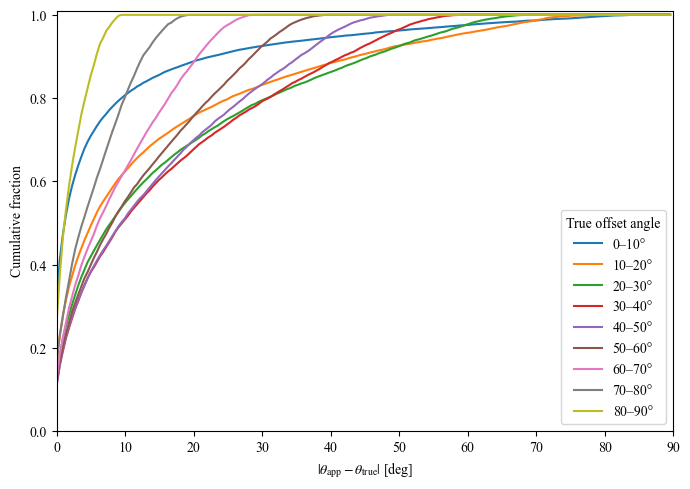

In [1394]:


delta_max = 90    
delta_bins = np.linspace(0, delta_max, 200)

plt.figure(figsize=(7,5))

for i in range(len(true_bins)-1):
    
    mask = (true_deg >= true_bins[i]) & (true_deg < true_bins[i+1])
    if np.sum(mask) < 1:
        continue  

    hist, edges = np.histogram(delta_deg[mask],bins=delta_bins,density=True)

    cdf = np.cumsum(hist) * np.diff(edges)

    plt.plot(edges[:-1],cdf,label=f'{true_bins[i]:.0f}–{true_bins[i+1]:.0f}°')

#plt.axhline(0.9, color='k', ls='--', lw=1)
#plt.axvline(5, color='k', ls=':', lw=1)

plt.xlabel(r'$|\theta_{\rm app} - \theta_{\rm true}|$ [deg]')
plt.ylabel('Cumulative fraction')
plt.legend(title='True offset angle')
plt.xlim(0, delta_max)
plt.ylim(0, 1.01)
plt.tight_layout()
plt.show()

In [1395]:
# Convert to degrees if not already
true_deg = np.degrees(true_offset_angle)
app_deg  = np.degrees(apparent_offset_angle)

# Absolute difference
delta_deg = np.abs(app_deg - true_deg)

# Fraction within 10 degrees
frac_within_10 = np.sum(delta_deg <= 20) / len(delta_deg)

print(f"Fraction of galaxies with apparent angle within 10° of true: {frac_within_10*100:.3f}")

Fraction of galaxies with apparent angle within 10° of true: 77.052


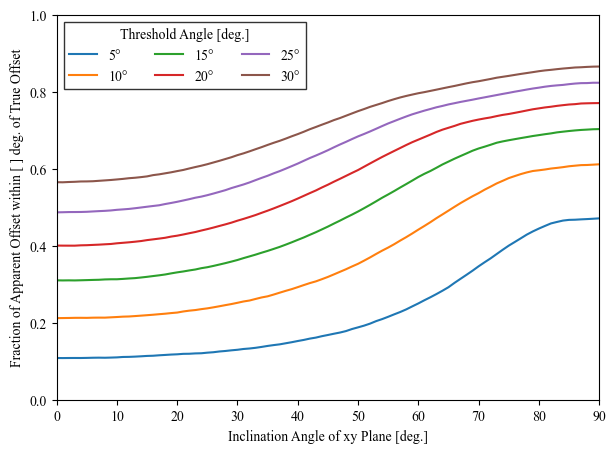

In [1396]:
# 

inclinations = np.arange(0, 91, 1)
true_deg = np.degrees(true_offset_angle)

plt.figure(figsize=(7,5))

for threshold in [5,10,15,20,25,30]:
    fractions_within_thresh = []
    
    for inc_deg in inclinations:
        inc = np.radians(inc_deg)
        
        # rotate y-z plane by inclination
        x_rot = x
        y_rot = y * np.cos(inc) - z * np.sin(inc)
        z_rot = y * np.sin(inc) + z * np.cos(inc)
        
        # apparent offset angle along projected axes
        app_rot_deg = np.degrees(np.arctan(np.abs(z_rot) / np.abs(x_rot)))
        
        # fraction within threshold degrees
        delta_deg = np.abs(app_rot_deg - true_deg)
        frac = np.sum(delta_deg <= threshold) / len(delta_deg)
        fractions_within_thresh.append(frac)
    
    # plot with label for this threshold
    plt.plot(inclinations, fractions_within_thresh[::-1], label=f'{threshold}°')

plt.xlabel('Inclination Angle of xy Plane [deg.]')
plt.ylabel('Fraction of Apparent Offset within [ ] deg. of True Offset')
plt.xlim(0, 90)
plt.ylim(0, 1)
plt.legend(title='Threshold Angle [deg.]',ncol=3,fancybox=False,edgecolor='k')
plt.show()

## SAGA

In [4]:
# combine table C1 and C3, attach host properties to each satellite

saga_host_path = 'saga-dr3-tableC1.txt'
saga_sats_path = 'saga-dr3-tableC3.txt'
saga_hosts = Table.read(saga_host_path, format='ascii')
saga_sats = Table.read(saga_sats_path, format = 'ascii')
saga_joined = join(saga_sats, saga_hosts, 'HOSTID', 'left',uniq_col_name='{table_name}{col_name}',table_names=['', 'HOST_'])

#print(saga_joined)

### Filters and Cuts on SAGA Data

In [5]:
# subselect the 3 different samples in the SAGA survey: gold, silver, participation

''' 1 = Gold;
    2 = Silver;
    3 = Participation'''

gold_filter = saga_sats['sample']== 1
silver_filter = saga_sats['sample'] == 2
participation_filter = saga_sats['sample'] == 3

In [6]:
# g-r color selection (use 0.7 as the division)
# where did this choice come from?

gr = np.array(saga_hosts['gr'].data)
blue_filter = gr<0.7
red_filter = gr >0.7


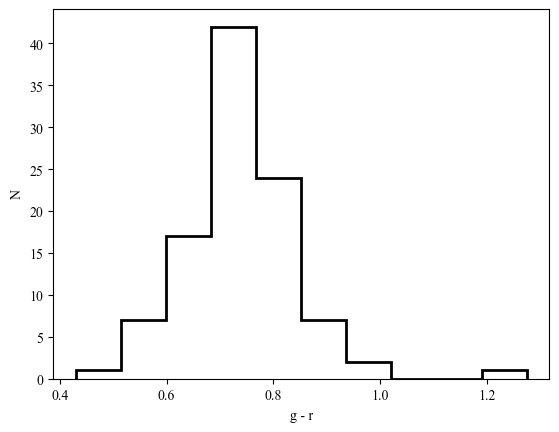

In [7]:
# plot color distribution 

plt.hist(gr,color='k',histtype='step',linewidth=2)
plt.xlabel('g - r')
plt.ylabel('N')
plt.show()

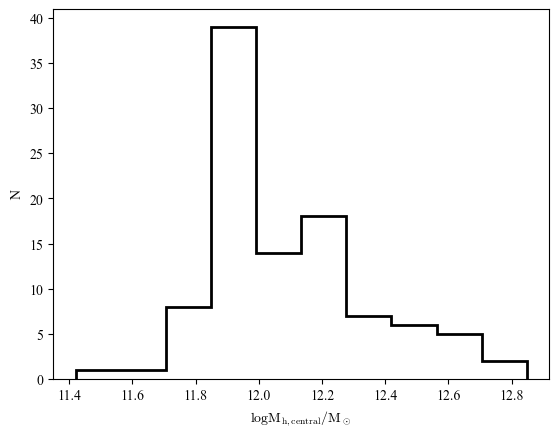

In [8]:
# r200 calculation, from Jingyao

def calc_r200(mhalo, do_print=False):

    import astropy.constants as const
    from astropy.cosmology import Planck18 as cosmo
    import astropy.units as u
    import numpy as np
    import sys


    mhalo = mhalo*u.Msun
    delta = 200 ## rho/rho_crit=200

    # calculate r200 with respect to critical density
    rho_c = cosmo.critical_density0
    r200_c = ((3*mhalo/(4.*np.pi*delta*rho_c))**(1./3.)).to(u.kpc)


    # calculate r200 with respect to matter density
    rho_m = cosmo.critical_density0 * cosmo.Om0
    r200_m = ((3*mhalo/(4.*np.pi*delta*rho_m))**(1./3.)).to(u.kpc)
    
    return r200_c.value, r200_m.value

# load Mhalo and calculate R200
hosts_log_mhalo_array = saga_hosts['log(Mhalo)'].data
r200c,r200m = calc_r200((10**hosts_log_mhalo_array))

# plot halo mass distribution

plt.hist(hosts_log_mhalo_array,color='k',histtype='step',linewidth=2)
plt.xlabel(r'$\mathrm{logM_{h,central}/M_\odot}$')
plt.ylabel('N')
plt.show()

### Calculating Azimuthal Angle from Major Axis

In [9]:
# print data 

saga_sats

OBJID,HOSTID,PGC,RAdeg,DEdeg,Rhost,rmag,e_rmag,gr,rmag-fiber,sb,ba,PA,Sersic,TELNAME,z,DVhost,log(M*),EW-Halpha,e_EW-Halpha,log(sfr)Halpha,e_log(sfr)Halpha,NUVmag,e_NUVmag,f_NUVmag,log(sfr)NUV,e_log(sfr)NUV,quenched,log(MHI),HIsource,flux-Halpha,e_flux-Halpha,flux-Hbeta,e_flux-Hbeta,flux-NII,e_flux-NII,flux-OIII,e_flux-OIII,flux-SII6717,e_flux-SII6717,flux-SII6731,e_flux-SII6731,flux-note,sample
,,,deg,deg,kpc,mag,mag,mag,mag,mag / arcsec2,,deg,,,,km / s,dex(Msun),1e-10 m,1e-10 m,dex(Msun / yr),dex(Msun / yr),mag,mag,,dex(Msun / yr),dex(Msun / yr),,dex(Msun),,1e-19 W / (nm m2),1e-19 W / (nm m2),1e-19 W / (nm m2),1e-19 W / (nm m2),1e-19 W / (nm m2),1e-19 W / (nm m2),1e-19 W / (nm m2),1e-19 W / (nm m2),1e-19 W / (nm m2),1e-19 W / (nm m2),1e-19 W / (nm m2),1e-19 W / (nm m2),,
int64,str9,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,str7,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64
900315730000006229,pgc68312,127631,334.0148085,-64.8787862,216.512,15.586,0.0008,0.465,20.087,21.854,0.678,135.099,1.185,AAT,0.01014,73.321,8.736,12.073,0.3986,-1.544,0.0337,18.508,0.052,1,-1.61,0.0827,0,--,--,1781.456,48.314,570.628,62.299,313.982,33.007,774.563,46.687,461.423,32.208,317.827,27.779,1,1
900316320000001800,pgc1952,-1,8.2736807,-64.6349444,234.685,19.014,0.0065,0.436,22.148,23.336,0.542,0.113,0.839,AAT,0.00859,-49.475,7.187,2.372,0.804,--,--,22.263,0.288,0,-3.257,0.1403,1,--,--,15.442,4.567,2.346,2.018,3.372,3.596,10.537,3.913,1.751,2.549,1.853,3.377,1,2
900322490000007741,pgc1952,1951,8.0041237,-64.3899958,80.501,14.046,0.0002,0.345,19.004,20.943,0.192,113.186,1.366,AAT,0.00916,123.04,9.075,61.071,2.5631,-0.433,0.0361,15.49,0.05,1,-0.548,0.0825,0,--,--,35702.422,580.374,11579.828,408.988,4287.794,404.955,29759.095,965.975,5627.409,401.067,4329.746,367.306,1,1
900328120000004044,pgc68312,68196,332.5294118,-64.5782122,294.065,13.874,0.0002,0.628,19.737,21.468,0.366,48.209,1.065,MIKE,0.00997,22.43,9.6,14.7,0.4,-0.787,0.0331,17.328,0.051,1,-1.138,0.0826,0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,0,1
900328130000003547,pgc68312,322039,333.1089681,-64.5071804,244.484,15.916,0.0006,0.431,18.836,20.65,0.892,140.451,1.665,AAT,0.00937,-157.52,8.567,37.049,1.3828,-1.242,0.035,17.998,0.051,1,-1.405,0.0826,0,--,--,3936.819,48.259,1290.943,36.41,385.725,36.526,2928.618,91.54,554.457,35.047,408.554,35.277,1,1
900328140000005155,pgc68312,-1,333.8210676,-64.5983783,236.665,18.469,0.0065,0.625,23.162,24.535,0.794,-8.997,0.838,COADD,0.00917,-218.003,7.759,-3.515,1.8081,--,--,21.715,4.131,0,-2.892,1.6543,1,--,--,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
900335040000000543,pgc1952,-1,7.9480205,-64.0995786,91.959,19.714,0.0064,0.364,22.25,23.426,0.579,48.339,1.0,AAT,0.00881,16.479,6.828,16.704,1.2187,-3.22,0.042,22.397,0.276,0,-3.31,0.1363,0,--,--,45.294,2.624,13.633,3.303,4.697,1.513,20.835,4.777,5.507,1.656,3.953,0.976,1,2
900335040000004860,pgc1952,-1,8.178446,-64.0559986,124.203,19.195,0.0034,0.556,21.338,22.338,0.736,0.908,0.91,AAT,0.00853,-67.462,7.247,-0.979,0.6117,--,--,23.547,0.655,0,-3.77,0.2739,1,--,--,11.149,3.167,1.907,1.569,1.716,1.877,25.764,4.752,3.222,1.384,2.984,1.173,1,2


In [10]:
# calculate angle

saga_PA = np.zeros(len(saga_sats))
saga_quenched = saga_sats['quenched'].data
for m in range(len(saga_hosts)):
    h_c = SkyCoord(saga_hosts['RAdeg'][m],saga_hosts['DEdeg'][m], frame = "icrs", unit = "deg")
    
    for n in range(len(saga_sats)):

        if saga_hosts['HOSTID'][m] == saga_sats['HOSTID'][n]:

            PA = saga_hosts['PA'][m]
            s_c = SkyCoord(saga_sats['RAdeg'][n],saga_sats['DEdeg'][n], frame = "icrs", unit = "deg")
            relative_angle = h_c.position_angle(s_c).degree
            #print(relative_angle)
            relative_angle_corrected = 90 + relative_angle
            #PA_central = customSimbad.query_object(saga_hosts['HOSTID'][m])['GALDIM_ANGLE'].value
            #print((90 - PA) + relative_angle)
            angle_final = ((90 - PA) + relative_angle_corrected)%360
            saga_PA[n] = angle_final

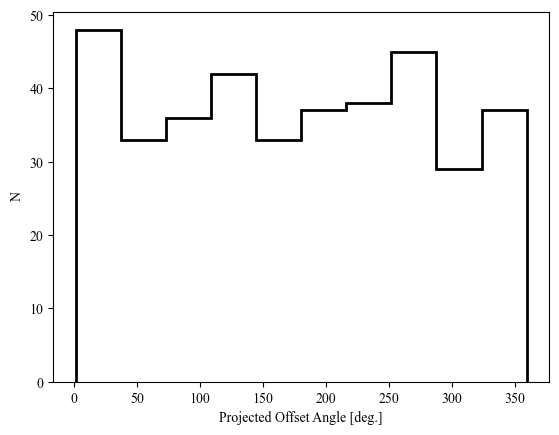

In [11]:
# plot angle distribution

plt.hist(saga_PA,color='k',histtype='step',linewidth=2)
plt.xlabel(r'Projected Offset Angle [deg.]')
plt.ylabel('N')
plt.show()

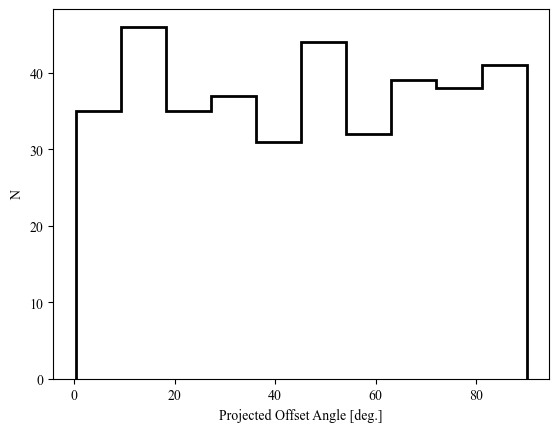

In [12]:
# convert to 0-90

def map_to_0_90(angles):

    angles = np.mod(angles, 360)
    return np.where(angles <= 90, angles,  
           np.where(angles <= 180, 180 - angles,  
           np.where(angles <= 270, angles - 180,  
                    360 - angles))) 

# plot angle distribution

plt.hist(map_to_0_90(saga_PA),color='k',histtype='step',linewidth=2)
plt.xlabel(r'Projected Offset Angle [deg.]')
plt.ylabel('N')
plt.show()

In [13]:
# apply radius limit 

#lmc_limit = saga_sats_gmag < 19

r200c_hosts = np.zeros(len(saga_sats))
r200m_hosts = np.zeros(len(saga_sats))

sats_rhost_array = saga_sats['Rhost'].data

host_data = {saga_hosts['HOSTID'][i]: hosts_log_mhalo_array[i] for i in range(len(saga_hosts))}

# Iterate over the satellites in saga_sats, and match each with its host using HOSTID
for i in range(len(saga_sats)):
    host_id = saga_sats['HOSTID'][i]  # Get the host ID of the current satellite
    # Check if the host exists in saga_hosts
    if host_id in host_data:
        host_mhalo = host_data[host_id]  # Get the host distance 
        mhalo = 10**host_mhalo #since the mhalo is given as the logarithm
        r200c,r200m = calc_r200(mhalo)
        r200c_hosts[i] = r200c
         
radius_limit = sats_rhost_array < r200c_hosts

In [14]:
# make a few different subselections:

sample = np.array(saga_sats['sample'])

index1 = (sats_rhost_array < r200c_hosts) & (sample == 1.)
index2 = (sats_rhost_array < r200c_hosts) & (sample == 2.)
index3 = (sats_rhost_array < r200c_hosts) & (sample == 3.)

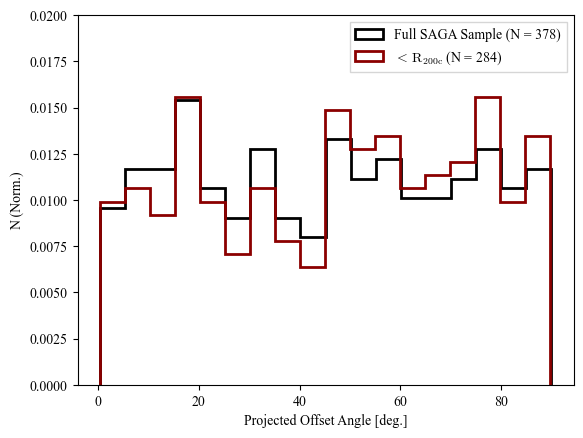

In [15]:
# compare entire SAGA sample with different subselections 

plt.hist(map_to_0_90(saga_PA),color='k',histtype='step',linewidth=2, density = True, bins = 18, label = r'Full SAGA Sample (N = %i)'%len(saga_PA))
plt.hist(map_to_0_90(saga_PA[radius_limit]),color='darkred',histtype='step',linewidth=2, density = True, bins = 18, label = r'$\mathrm{<\,R_{200c}}$ (N = %i)'%len(saga_PA[radius_limit]))

plt.xlabel(r'Projected Offset Angle [deg.]')
plt.ylabel('N (Norm.)')
plt.legend(loc='upper right', fancybox = False)

plt.ylim(0,0.020)

plt.show()

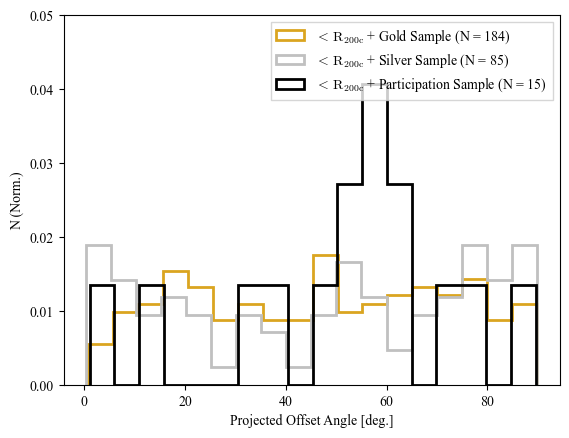

In [16]:
# compare entire SAGA sample with different subselections 

#plt.hist(map_to_0_90(saga_PA),color='k',histtype='step',linewidth=2, density = True, bins = 18, label = r'Full SAGA Sample (N = %i)'%len(saga_PA))
plt.hist(map_to_0_90(saga_PA[index1]),color='goldenrod',histtype='step',linewidth=2, density = True, bins = 18, label = r'$\mathrm{<\,R_{200c}}$ + Gold Sample (N = %i)'%len(saga_PA[index1]))
plt.hist(map_to_0_90(saga_PA[index2]),color='silver',histtype='step',linewidth=2, density = True, bins = 18, label = r'$\mathrm{<\,R_{200c}}$ + Silver Sample (N = %i)'%len(saga_PA[index2]))
plt.hist(map_to_0_90(saga_PA[index3]),color='k',histtype='step',linewidth=2, density = True, bins = 18, label = r'$\mathrm{<\,R_{200c}}$ + Participation Sample (N = %i)'%len(saga_PA[index3]))

plt.xlabel(r'Projected Offset Angle [deg.]')
plt.ylabel('N (Norm.)')
plt.legend(loc='upper right', fancybox = False)

plt.ylim(0,0.050)

plt.show()

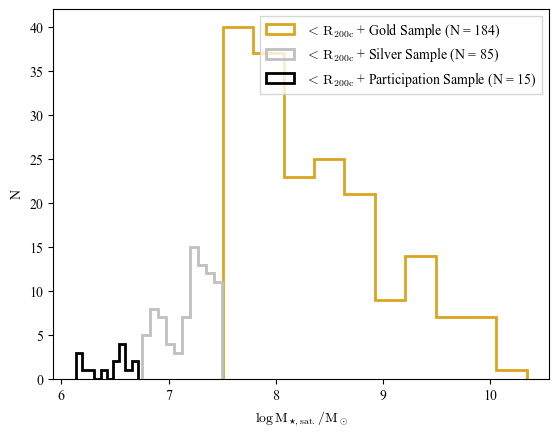

In [17]:
# compare the different SAGA samples (based on satellite stellar mass)

saga_mstar = saga_sats['log(M*)']

plt.hist(saga_mstar[index1],color='goldenrod',histtype='step',linewidth=2, density =False, label = r'$\mathrm{<\,R_{200c}}$ + Gold Sample (N = %i)'%len(saga_mstar[index1]))
plt.hist(saga_mstar[index2],color='silver',histtype='step',linewidth=2, density =False, label = r'$\mathrm{<\,R_{200c}}$ + Silver Sample (N = %i)'%len(saga_mstar[index2]))
plt.hist(saga_mstar[index3],color='k',histtype='step',linewidth=2, density =False, label = r'$\mathrm{<\,R_{200c}}$ + Participation Sample (N = %i)'%len(saga_mstar[index3]))

plt.xlabel(r'$\mathrm{log\, M_{\star,sat.}/M_\odot}$')
plt.ylabel('N')
plt.legend(loc='upper right', fancybox = False)

#plt.ylim(0,0.050)

plt.show()

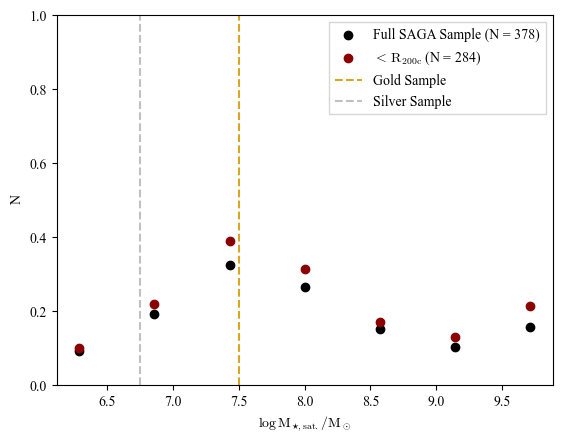

In [18]:
quenched = np.array(saga_sats['quenched'])

q_frac, bin_edges, binnumber = scipy.stats.binned_statistic(saga_mstar,quenched,statistic='mean',bins=7,range=[6,10])
plt.scatter((bin_edges[:-1]+bin_edges[1:])/2,q_frac,color='black', label = r'Full SAGA Sample (N = %i)'%len(saga_PA))

q_frac, bin_edges, binnumber = scipy.stats.binned_statistic(saga_mstar[radius_limit],quenched[radius_limit],statistic='mean',bins=7,range=[6,10])
plt.scatter((bin_edges[:-1]+bin_edges[1:])/2,q_frac,color='darkred', label = r'$\mathrm{<\,R_{200c}}$ (N = %i)'%len(saga_PA[radius_limit]))

plt.axvline(7.5,ls='--',color='goldenrod',label='Gold Sample')
plt.axvline(6.75,ls='--',color='silver',label='Silver Sample')
 
plt.xlabel(r'$\mathrm{log\, M_{\star,sat.}/M_\odot}$')
plt.ylabel('N')
plt.legend(loc='upper right', fancybox = False)
plt.ylim(0,1)
plt.show()

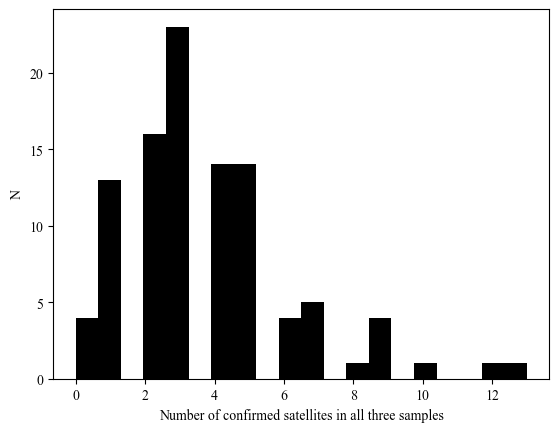

[0 0 0 0]


In [19]:
# there are 4 hosts with no satellites
# nsat-GSPc = Number of confirmed satellites in all three samples: Gold, Silver, Participation

plt.hist(saga_hosts['nsat-GSPc'],bins=20,color='k')
plt.xlabel(r'Number of confirmed satellites in all three samples')
plt.ylabel('N')

plt.show()

print(np.array(saga_hosts['nsat-GSPc'])[np.array(saga_hosts['nsat-GSPc']) == 0])

In [20]:
# there are 16 hosts in the Gold sample with no Gold sample mass (logM > 7.5) satellites 

len(saga_hosts['nsat-Gc'][saga_hosts['nsat-Gc'] == 0])

16

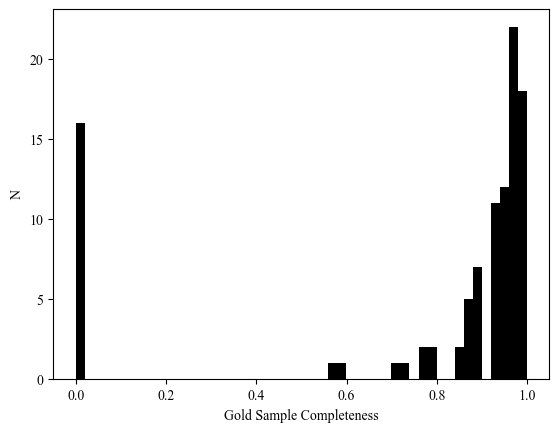

In [21]:
# Gold sample completeness

plt.hist(saga_hosts['nsat-Gc']/saga_hosts['nsat-G'],bins=50,color='k')
plt.xlabel(r'Gold Sample Completeness')
plt.ylabel('N')

plt.show()

In [22]:
import astropy.units as u

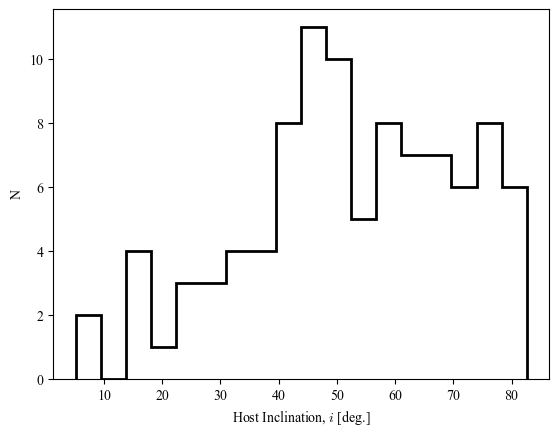

In [23]:
hostid, idx = np.unique(saga_joined['HOSTID'],return_index=True)
host_ba = saga_joined['HOST_ba'][idx]
host_inclination = (np.arccos(host_ba)*u.rad).to('deg')

plt.hist(host_inclination,color='k',histtype='step', bins = 18, linewidth=2, density =False)

plt.xlabel(r'Host Inclination, $i$ [deg.]')
plt.ylabel('N')
#plt.legend(loc='upper right', fancybox = False)
#plt.ylim(0,1)
plt.show()

In [24]:
host_ba = saga_joined['HOST_ba']
host_inclination = np.array((np.arccos(host_ba)*u.rad).to('deg'))

index_inclination = (host_inclination >= 0)

index_inclination_ids = np.array(saga_joined['HOSTID'])[index_inclination]

In [25]:
# make a few different subselections:

index_inclination_ids = np.array(saga_joined['HOSTID'])[index_inclination]

HOSTID = np.array(saga_sats['HOSTID'])

index1 = (sats_rhost_array < r200c_hosts) & ((sample == 1.) | (sample == 1.))  & (np.isin(HOSTID,index_inclination_ids))
#index2 = (sats_rhost_array < r200c_hosts) & (sample == 2.)
#index3 = (sats_rhost_array < r200c_hosts) & (sample == 3.)

In [26]:
print('number of SAGA hosts =',len(np.unique(saga_sats['HOSTID'][index1])))
print('number of SAGA satellites =',len(np.unique(saga_PA[index1])))

number of SAGA hosts = 78
number of SAGA satellites = 184


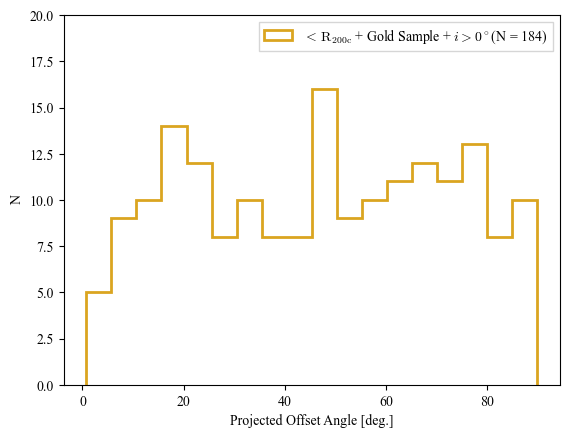

In [27]:
# compare entire SAGA sample with different subselections 

plt.hist(map_to_0_90(saga_PA[index1]),color='goldenrod',histtype='step',linewidth=2, density = False, bins = 18, label = r'$\mathrm{<\,R_{200c}}$ + Gold Sample + $i > 0^\circ$(N = %i)'%len(saga_PA[index1]))
#plt.hist(map_to_0_90(saga_PA[index2]),color='silver',histtype='step',linewidth=2, density = True, bins = 18, label = r'$\mathrm{<\,R_{200c}}$ + Silver Sample (N = %i)'%len(saga_PA[index2]))
#plt.hist(map_to_0_90(saga_PA[index3]),color='k',histtype='step',linewidth=2, density = True, bins = 18, label = r'$\mathrm{<\,R_{200c}}$ + Participation Sample (N = %i)'%len(saga_PA[index3]))

plt.xlabel(r'Projected Offset Angle [deg.]')
plt.ylabel('N')
plt.legend(loc='upper right', fancybox = False)

plt.ylim(0,20)

plt.show()

In [28]:
# final sample, where we only select satellites within r200c of the host galaxy

#saga_PA = saga_PA[radius_limit]
#saga_quenched = saga_quenched[radius_limit]

saga_PA = saga_PA[index1]
saga_90 = map_to_0_90(saga_PA)
saga_quenched = saga_quenched[index1]

## Importing and Processing ELVES

In [29]:
# import ELVES data 

sats = pd.read_csv('Carlsten22_ELVES_confirmed_sats - Carlsten22_ELVES_confirmed_sats_compre.csv')
hosts_unfiltered = pd.read_csv("Carlsten22_ELVES_host - Carlsten22_ELVES_host.csv")
s_host = pd.read_csv("saga_host_compre.csv")

In [30]:
s_host

,Name,Mstar,M_K,SHMMhalo,SHMRvir,SHMVesc,SAGAMhalo,Nsat,N_HI,N_HI_massive,N_HI_dim
0,UGC00903,10.260296,-23.535062,11.826887,184.754314,176.783440,11.931141,4,4,4,4
1,NGC1015,10.331776,-23.495667,11.882027,192.741266,184.425809,11.938141,2,2,2,2
2,NGC1309,10.275148,-23.573914,11.838060,186.345573,178.306046,11.853141,3,2,2,1
3,PGC013646,10.249901,-23.141505,11.819148,183.660213,175.736542,12.060141,3,3,3,2
4,ESO121-026,10.572992,-23.710564,12.102627,228.301042,218.451426,12.209141,2,2,2,1
5,NGC2543,10.509130,-23.455076,12.037670,217.197867,207.827277,11.827141,2,2,2,0
6,UGC04906,10.355138,-23.363034,11.900855,195.546792,187.110297,11.954141,6,6,6,3
7,NGC2962,10.724018,-24.046563,12.283374,262.275156,250.959792,12.376141,4,4,4,2
8,NGC2967,10.350918,-23.513355,11.897422,195.032227,186.617931,12.020141,1,2,1,2
9,NGC3689,10.447154,-23.797960,11.979643,207.736720,198.774313,12.244141,2,0,0,0


In [31]:
sats

,Host,Sat_name,RA(deg),DEC(deg),D_SBF(Mpc),D_TRGB(Mpc),Vel(km/s),dvel,Rproj(kpc),Rproj_in_Rvir?,Theta,ETG?,M_g,lgM_star
0,NGC253,NGC247,11.783,-20.757,NaN,3.72,159.0,-100.0,282.2,0,1.092086,0,-18.31,9.41
1,NGC253,dw0047m2623,11.894,-26.390,NaN,3.90,NaN,NaN,68.5,1,NaN,1,-8.86,5.77
2,NGC253,dw0049m2100,12.454,-21.017,NaN,3.44,295.0,36.0,267.9,1,0.981759,0,-12.69,6.62
3,NGC253,dw0050m2444,12.575,-24.737,NaN,3.12,NaN,NaN,51.7,1,NaN,1,-9.53,5.53
4,NGC253,dw0055m2309,13.754,-23.169,NaN,NaN,250.0,-9.0,169.0,1,0.614256,0,-10.26,5.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,NGC6744,dw1905m6316,286.483,-63.272,7.61,NaN,NaN,NaN,113.2,1,NaN,1,-11.44,6.70
247,NGC6744,dw1906m6357,286.742,-63.964,7.31,NaN,NaN,NaN,50.9,1,NaN,1,-13.33,7.46
248,NGC6744,dw1907m6342,286.844,-63.706,7.99,NaN,NaN,NaN,47.6,1,NaN,1,-11.88,6.71
249,NGC6744,dw1908m6343,287.183,-63.730,5.33,NaN,NaN,NaN,26.7,1,NaN,0,-15.21,7.68


In [32]:
from astroquery.simbad import Simbad

customSimbad = Simbad()
customSimbad.reset_votable_fields()
# Add degree-valued RA/DEC + host PA
customSimbad.add_votable_fields('ra', 'dec', 'galdim_angle','galdim_majaxis','galdim_minaxis')


In [33]:
hosts_unfiltered['Host']

0         M31
1      NGC253
2      NGC628
3      NGC891
4     NGC1023
5     NGC1291
6     NGC1808
7     NGC2683
8     NGC2903
9         M81
10    NGC3115
11    NGC3344
12    NGC3379
13    NGC3521
14    NGC3556
15    NGC3621
16    NGC3627
17    NGC4258
18    NGC4517
19    NGC4565
20       M104
21    NGC4631
22    NGC4736
23    NGC4826
24    NGC5055
25      CEN A
26    NGC5194
27    NGC5236
28    NGC5457
29    NGC6744
30         MW
Name: Host, dtype: object

In [34]:
# get position angle from ELVES hosts 

hosts_missing_pa = []
pa_val = []
elves_inclination = []
#elves_PA = []
pa_indices = []

for i, host in enumerate(hosts_unfiltered['Host']):
    tab = customSimbad.query_object(host)

    val = tab['galdim_angle']
    major_axis = tab['galdim_majaxis']
    minor_axis = tab['galdim_minaxis']
    
    #print(val[0])
    pa_val.append(val.value)
    if np.ma.is_masked(val):
        hosts_missing_pa.append(host)
    else:
        pa_indices.append(i)
        #print(major_axis)
        #print(minor_axis)
        #print(' d')
        elves_inclination.append(np.arccos(minor_axis/major_axis)*180/np.pi)
        #elves_PA.append(val)

hosts  = hosts_unfiltered.iloc[pa_indices].copy()
print("Hosts missing GALDIM_ANGLE:")
for h in hosts_missing_pa:
    print(h)
    print(customSimbad.query_object(h)['galdim_angle'])


Hosts missing GALDIM_ANGLE:
NGC1023
galdim_angle
    deg     
------------
          --
NGC3379
galdim_angle
    deg     
------------
          --
NGC4258
galdim_angle
    deg     
------------
          --
NGC5236
galdim_angle
    deg     
------------
          --
NGC5457
galdim_angle
    deg     
------------
          --


In [1440]:
NGC1023, 90  # https://ned.ipac.caltech.edu/byname?objname=NGC1023&hconst=67.8&omegam=0.308&omegav=0.692&wmap=4&corr_z=1
NGC3379, spherical: 90 or 0  # https://ned.ipac.caltech.edu/byname?objname=NGC3379&hconst=67.8&omegam=0.308&omegav=0.692&wmap=4&corr_z=1
NGC4258, 150 # https://ned.ipac.caltech.edu/byname?objname=NGC4258&hconst=67.8&omegam=0.308&omegav=0.692&wmap=4&corr_z=1
NGC5236, face-on: 0 # https://ned.ipac.caltech.edu/byname?objname=NGC5236&hconst=67.8&omegam=0.308&omegav=0.692&wmap=4&corr_z=1
NGC5457, also face-on # https://ned.ipac.caltech.edu/byname?objname=NGC5457&hconst=67.8&omegam=0.308&omegav=0.692&wmap=4&corr_z=1

SyntaxError: only single target (not tuple) can be annotated (2580781012.py, line 2)

In [35]:
# plot ELVES host inclination

elves_inclination_reformat = np.concatenate([c.filled(np.nan) for c in elves_inclination])
elves_PA_reformat = np.concatenate([c.astype(float).filled(np.nan) for c in elves_PA])

plt.hist(data_array,color='k',bins=18)
plt.xlabel("ELVES Host Inclination [deg.]")
plt.ylabel("N")
plt.show()

NameError: name 'elves_PA' is not defined

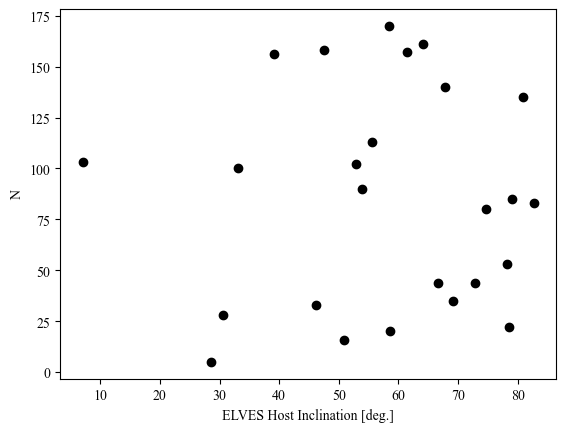

In [1442]:
plt.scatter(elves_inclination_reformat,elves_PA_reformat,color='k')
plt.xlabel("ELVES Host Inclination [deg.]")
plt.ylabel("N")
plt.show()

In [36]:
valid_indices = []

for i, host in enumerate(hosts_unfiltered['Host']):
    tab = customSimbad.query_object(host)
    val = tab['galdim_angle']

    if not np.ma.is_masked(val):  # keep only if PA exists
        valid_indices.append(i)

# Keep only rows with valid PA
hosts = hosts_unfiltered.iloc[valid_indices].copy()

In [37]:
import numpy as np
from astropy.coordinates import SkyCoord

pa_list, dproj_list, mass_list = [], [], []
kept_indices = []  # optional: lets you map back to rows in `sats`

for r in range(len(sats)):
    host = sats['Host'].get(r)

    # Query host once each place we need
    h_table = Simbad.query_object(host)
    pa_tab  = customSimbad.query_object(host)

    # Skip if PA is missing/masked
    pa_col = pa_tab['galdim_angle']
    if np.ma.is_masked(pa_col):
        continue

    # Build coords (skip if satellite coords missing)
    try:
        h_coords = SkyCoord(ra=h_table['ra'], dec=h_table['dec'], frame='icrs')
        s_coords = SkyCoord(ra=sats['RA(deg)'].get(r),
                            dec=sats['DEC(deg)'].get(r),
                            frame='icrs', unit='deg')
    except Exception:
        # If any coord is malformed, skip this row
        continue

    position_angle = h_coords.position_angle(s_coords).degree

    # Compute the angle using GALDIM_ANGLE value
    angle = ((90 - pa_col.value) + position_angle + 90) % 360

    # Append valid values
    pa_list.append(angle)
    dproj_list.append(sats['Rproj(kpc)'].get(r))
    mass_list.append(sats['lgM_star'].get(r))
    kept_indices.append(r)

# Final arrays contain ONLY rows with valid PA
elves_PA    = np.array(pa_list, dtype=float)
elves_dproj = np.array(dproj_list, dtype=float)
elves_mass  = np.array(mass_list, dtype=float)

In [38]:
#elves position angles

n_theta = np.zeros(len(elves_PA))  
    
for n in range(len(elves_PA)):
    angle_val = float(elves_PA[n])  # Convert to scalar to avoid deprecation warning
    if angle_val > 180:
        n_theta[n] = (180 - (angle_val % 180))
    else: 
        n_theta[n] = angle_val
        
#sats_filter =  (sats['lgM_star']<(10**10))&(sats['Rproj_in_Rvir?']==1)


/var/folders/g8/yhp4yljs3hnc8p358tbh51680000gn/T/ipykernel_31666/4268276075.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  angle_val = float(elves_PA[n])  # Convert to scalar to avoid deprecation warning


In [39]:
#elves quench values
elves_quenched = sats['ETG?'].iloc[kept_indices]
elves_PA = elves_PA

In [40]:
print('number of ELVES hosts =',len(hosts))
print('number of ELVES satellites =',len(elves_PA))

number of ELVES hosts = 26
number of ELVES satellites = 177


# Working with Both ELVES and SAGA

### Quench Fraction Calculation

In [41]:

def bootstrap_error(data, n_bootstrap=10000):
    if len(data) == 0:
        return 0.0
    bootstraps = np.random.choice(data, size=(n_bootstrap, len(data)), replace=True)
    means = np.nanmean(bootstraps, axis=1)
    return np.std(means)
    
def quenched_fraction_with_bootstrap(angles, quenching, bin_size, window_size, angle_range=(0, 90), n_bootstrap=10000):
    
    angles = np.asarray(angles).flatten()
    quenching = np.asarray(quenching, dtype=float).flatten()
    
    centers = [] 
    means = []
    errors = []

    center_value = angle_range[0] + window_size
    
    while center_value <= angle_range[1] - window_size:

        # Define window: angles within [center - window_size, center + window_size)
        in_window = (angles >= center_value - window_size) & (angles < center_value + window_size)
        values_in_window = quenching[in_window]

        # Store center
        centers.append(center_value)

        # Compute moving mean and bootstrap error
        means.append(np.nanmean(values_in_window))
        errors.append(bootstrap_error(values_in_window, n_bootstrap=n_bootstrap))

        # Move to next window center
        center_value += bin_size
        
    return np.array(centers), np.array(means), np.array(errors)

In [42]:

def bootstrap_error(data, n_bootstrap=10000):
    if len(data) == 0:
        return 0.0
    bootstraps = np.random.choice(data, size=(n_bootstrap, len(data)), replace=True)
    means = np.nanmean(bootstraps, axis=1)
    return np.std(means)
    
def quenched_fraction_with_bootstrap(angles, quenching, bin_size, window_size, angle_range=(0, 90), n_bootstrap=10000):
    
    angles = np.asarray(angles).flatten()
    quenching = np.asarray(quenching, dtype=float).flatten()
    
    centers = [] 
    means = []
    errors = []

    center_value = angle_range[0] + 2.5
    
    while center_value < 90:

        # Define window: angles within [center - window_size, center + window_size)
        in_window = (angles >= center_value - 2.5) & (angles < center_value + 2.5)
        values_in_window = quenching[in_window]

        # Store center
        centers.append(center_value)

        # Compute moving mean and bootstrap error
        means.append(np.nanmean(values_in_window))
        #print(len(values_in_window))
        errors.append(bootstrap_error(values_in_window, n_bootstrap=n_bootstrap))

        # Move to next window center
        center_value += 5
        
    return np.array(centers), np.array(means), np.array(errors)

In [43]:
#saga data
saga_bins, saga_quench, saga_error = quenched_fraction_with_bootstrap(saga_90, saga_quenched, 5, 5)

In [56]:
# elves data
elves_90 = map_to_0_90(elves_PA)
elves_bins, elves_quench, elves_error = quenched_fraction_with_bootstrap(elves_90, elves_quenched,5,5)
elves_90_correct = []
for i in range(len(elves_90)):
    elves_90_correct.append(elves_90[i][0])

In [46]:
elves_mean = np.mean(elves_quenched)

In [47]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']  # Or 'Times'
plt.rcParams['mathtext.fontset'] = 'stix'  # For math symbols to match Times
plt.rcParams['mathtext.rm'] = 'Times New Roman'

## Normalized Count per Azimuthal Angle Bin

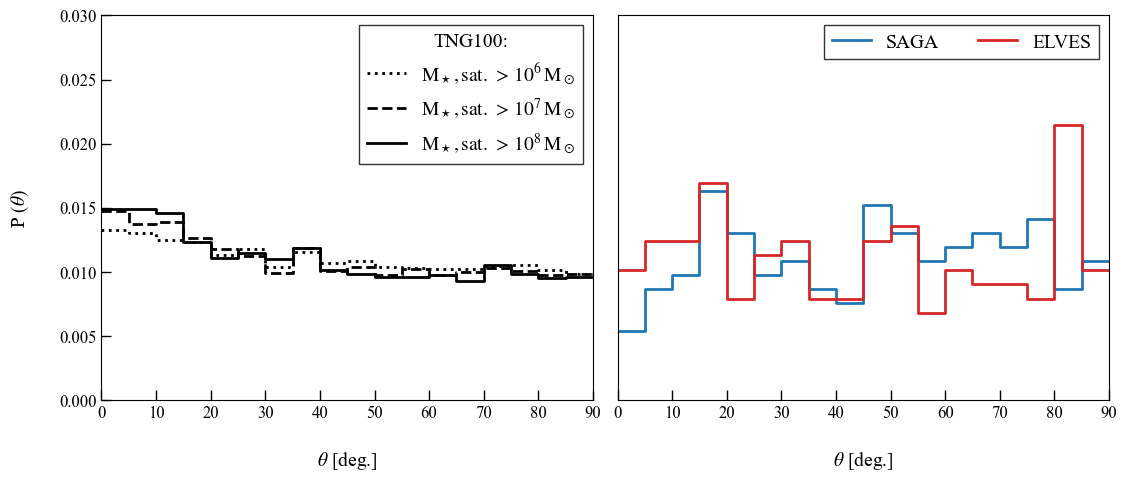

In [51]:
# New high-contrast colors
saga_line = '#1f77b4'
saga_fill = '#aec7e8'
elves_line = '#d62728'
elves_fill = '#ff9896'

fig, (ax_hist,ax_hist2) = plt.subplots(1, 2, figsize=(13, 5))

# ===============================
# TOP PANEL — STEP HISTOGRAM
# ===============================


# SDSS, TNG, SMDPL (from Michael)

# load data
angle_array = np.loadtxt('angle_array.txt')

tng100_number_count = np.loadtxt('tng100_number_count_1e8.txt')
tng100_number_count_1e7 = np.loadtxt('tng100_number_count_1e7.txt')
tng100_number_count_1e6 = np.loadtxt('tng100_number_count_1e6.txt')

tng_hist  = tng100_number_count / np.sum(tng100_number_count) / 5
tng_hist_1e7  = tng100_number_count_1e7 / np.sum(tng100_number_count_1e7) / 5
tng_hist_1e6  = tng100_number_count_1e6 / np.sum(tng100_number_count_1e6) / 5
smdpl_hist = smdpl_number_count / np.sum(smdpl_number_count) / 5
bin_width = np.diff(angle_array).mean()
edges = np.concatenate([angle_array - bin_width/2,[angle_array[-1] + bin_width/2]])

# plot 
#ax_hist.step(edges, np.r_[sdss_hist, sdss_hist[-1]], where="post", label="SDSS", lw = 2, color = 'black', ls = '-')
ax_hist.step(edges, np.r_[tng_hist_1e6,  tng_hist_1e6[-1]],  where="post", label=r"$\mathrm{M_\star,sat.\, >\, 10^6\, M_\odot}$", lw = 2, color = 'black', ls = ':')
ax_hist.step(edges, np.r_[tng_hist_1e7,  tng_hist_1e7[-1]],  where="post", label=r"$\mathrm{M_\star,sat.\, >\, 10^7\, M_\odot}$", lw = 2, color = 'black', ls = '--')
ax_hist.step(edges, np.r_[tng_hist,  tng_hist[-1]],  where="post", label=r"$\mathrm{M_\star,sat.\, >\, 10^8\, M_\odot}$", lw = 2, color = 'black', ls = '-')


#ax_hist.step(edges, np.r_[smdpl_hist, smdpl_hist[-1]], where="post", label="SMDPL", lw = 2, color = 'black', ls = ':')

#ax.axhline(5/90,color='black',ls='--',lw=2,label='Uniform Dist.')

saga_90 = map_to_0_90(saga_PA)
elves_90 = map_to_0_90(elves_PA)
bins = np.linspace(0, 90, 19)

counts_saga, _ = np.histogram(saga_90, bins=bins, density=True)
ax_hist2.step(bins, np.append(counts_saga, counts_saga[-1]),where='post', color=saga_line, linewidth=2, label='SAGA')

counts_elves, _ = np.histogram(elves_90, bins=bins, density=True)
ax_hist2.step(bins, np.append(counts_elves, counts_elves[-1]),where='post', color=elves_line, linewidth=2, label='ELVES')
#ax_hist.scatter(bins, np.append(counts_elves, counts_elves[-1]), color=elves_line, label='ELVES')

#angle_grid_deg = np.linspace(0, 90, 300)
#uniform_density = 1/90
#ax_hist.axhspan(uniform_density, uniform_density, color='black')

max_density = max(counts_saga.max(), counts_elves.max())

ax_hist.set_ylabel(r'P ($\theta$)', fontsize=14, labelpad=20)
ax_hist.set_xlabel(r'$\theta$ [deg.]', fontsize=14, labelpad=20)
ax_hist2.set_xlabel(r'$\theta$ [deg.]', fontsize=14, labelpad=20)

ax_hist.set_xlim(0, 90)
ax_hist2.set_xlim(0, 90)

ax_hist.set_ylim(0, 0.030)
ax_hist2.set_ylim(0, 0.030)

ax_hist.legend(fontsize=14,loc='upper right', fancybox=False, edgecolor='black',ncol=1,title='TNG100:',title_fontsize=14)
ax_hist2.legend(fontsize=14,loc='upper right', fancybox=False, edgecolor='black',ncol=2)

ax_hist.tick_params(axis="both", which="major", direction="in", labelsize=12, length=7, width=1)
ax_hist.tick_params(axis="both", which="minor", direction="in", labelsize=12, length=2, width=1)

ax_hist2.tick_params(axis="both", which="major", direction="in", labelsize=12, length=7, width=1)
ax_hist2.tick_params(axis="both", which="minor", direction="in", labelsize=12, length=2, width=1)

ax_hist2.set_yticks([])

plt.subplots_adjust(wspace=0.05)
plt.show()

### Mean Angle 

In [53]:
# import TNG100 data

df_tng100_1e8 = pd.read_csv("satellite_1e8/centrals_satellites_tng100_mstar_1e8.csv")
df_tng100_host_mh_1e8 = pd.read_csv("satellite_1e8/centrals_satellites_tng100_host_mh_1e8.csv")
df_tng100_alpha_1e8 = pd.read_csv("satellite_1e8/centrals_satellites_tng100_alpha_1e8.csv")

index_1e8 = (df_tng100_host_mh_1e8['host_mh'] > 12) & (df_tng100_host_mh_1e8['host_mh'] < 12.5)

df_tng100_1e7 = pd.read_csv("satellite_1e7/centrals_satellites_tng100_mstar_1e7.csv")
df_tng100_host_mh_1e7 = pd.read_csv("satellite_1e7/centrals_satellites_tng100_host_mh_1e7.csv")
df_tng100_alpha_1e7 = pd.read_csv("satellite_1e7/centrals_satellites_tng100_alpha_1e7.csv")

index_1e7 = (df_tng100_host_mh_1e7['host_mh'] > 12) & (df_tng100_host_mh_1e7['host_mh'] < 12.5)

df_tng100_1e6 = pd.read_csv("satellite_1e6/centrals_satellites_tng100_mstar_1e6.csv")
df_tng100_host_mh_1e6 = pd.read_csv("satellite_1e6/centrals_satellites_tng100_host_mh_1e6.csv")
df_tng100_alpha_1e6 = pd.read_csv("satellite_1e6/centrals_satellites_tng100_alpha_1e6.csv")

index_1e6 = (df_tng100_host_mh_1e6['host_mh'] > 12) & (df_tng100_host_mh_1e6['host_mh'] < 12.5)

In [54]:
print(np.mean(df_tng100_alpha_1e8[index_1e8]),np.std(df_tng100_alpha_1e8[index_1e8]))
print(np.mean(df_tng100_alpha_1e7[index_1e7]),np.std(df_tng100_alpha_1e7[index_1e7]))
print(np.mean(df_tng100_alpha_1e6[index_1e6]),np.std(df_tng100_alpha_1e6[index_1e6]))

41.34233432284182 alpha    26.573483
dtype: float64
41.86477813356116 alpha    26.525396
dtype: float64
42.85827496794586 alpha    26.253497
dtype: float64


/Users/messeremichael/miniforge3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


### One-Sample KS-Test

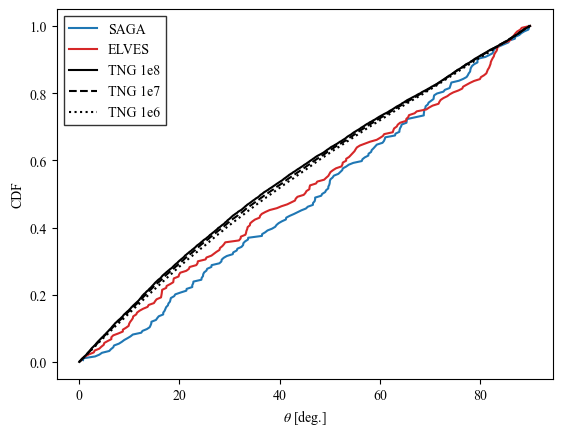

In [57]:
sort_saga = np.argsort(saga_90)
sort_elves = np.argsort(np.array(elves_90_correct))

cdf_saga = np.arange(1, len(saga_90)+1) / len(saga_90)
cdf_elves = np.arange(1, len(elves_90_correct)+1) / len(elves_90_correct)

plt.plot(saga_90[sort_saga], cdf_saga, color=saga_line, label='SAGA')
plt.plot(np.array(elves_90_correct)[sort_elves], cdf_elves, color=elves_line, label='ELVES')

angles_1d_1e8 = df_tng100_alpha_1e8.iloc[:,0].to_numpy()
sort_tng100_1e8 = np.argsort(angles_1d_1e8)
cdf_tng100_1e8 = np.arange(1, len(angles_1d_1e8)+1) / len(angles_1d_1e8)
plt.plot(angles_1d_1e8[sort_tng100_1e8], cdf_tng100_1e8, color='black', ls = '-', label='TNG 1e8')

angles_1d_1e7 = df_tng100_alpha_1e7.iloc[:,0].to_numpy()
sort_tng100_1e7 = np.argsort(angles_1d_1e7)
cdf_tng100_1e7 = np.arange(1, len(angles_1d_1e7)+1) / len(angles_1d_1e7)
plt.plot(angles_1d_1e7[sort_tng100_1e7], cdf_tng100_1e7, color='black', ls = '--', label='TNG 1e7')

angles_1d_1e6 = df_tng100_alpha_1e6.iloc[:,0].to_numpy()
sort_tng100_1e6 = np.argsort(angles_1d_1e6)
cdf_tng100_1e6 = np.arange(1, len(angles_1d_1e6)+1) / len(angles_1d_1e6)
plt.plot(angles_1d_1e6[sort_tng100_1e6], cdf_tng100_1e6, color='black', ls = ':', label='TNG 1e6')

# Plot

plt.xlabel(r'$\theta$ [deg.]')
plt.ylabel('CDF')
plt.legend(fancybox=False,edgecolor='k',ncol=1)
plt.show()

In [58]:
# implement one-sample K-S test
# see https://www.astroml.org/astroML-notebooks/chapter4/astroml_chapter4_Comparison_of_distributions.html

import scipy.stats as stats

# example from website
#np.random.seed(0)
#vals = np.random.normal(loc=0, scale=1, size= 1000)
#print(f'Normal: {stats.kstest(vals, "norm")}')
#print(f'Uniform: {stats.kstest(vals, "uniform")}')

print(f'Uniform: {stats.kstest(saga_90[sort_saga], "uniform",args=(0, 90))}')
print(f'Uniform: {stats.kstest(np.array(elves_90_correct)[sort_elves], "uniform",args=(0, 90))}')


print(f'Uniform: {stats.kstest(angles_1d_1e8[sort_tng100_1e8], "uniform",args=(0, 90))}')
print(f'Uniform: {stats.kstest(angles_1d_1e7[sort_tng100_1e7], "uniform",args=(0, 90))}')
print(f'Uniform: {stats.kstest(angles_1d_1e6[sort_tng100_1e6], "uniform",args=(0, 90))}')

Uniform: KstestResult(statistic=0.05844748725163064, pvalue=0.5363942541253537, statistic_location=14.064621678733715, statistic_sign=-1)
Uniform: KstestResult(statistic=0.052627365231793566, pvalue=0.6907804344863296, statistic_location=79.99070015899702, statistic_sign=-1)
Uniform: KstestResult(statistic=0.09527100759879048, pvalue=9.248156613097558e-122, statistic_location=33.58307219706744, statistic_sign=1)
Uniform: KstestResult(statistic=0.08587591311393866, pvalue=4.647500198708371e-199, statistic_location=33.58307219706744, statistic_sign=1)
Uniform: KstestResult(statistic=0.07537667051445024, pvalue=0.0, statistic_location=34.91709997343638, statistic_sign=1)


In [ ]:
from scipy import stats

In [1498]:
# calulate how many > 1e6 satellites are needed to find a significant difference from a uniform distribution

rng = np.random.default_rng(42) # set random seed

angles = df_tng100_alpha_1e6.iloc[:, 0].to_numpy() # > 1e6 satellite population

Ns = np.arange(10, 2000, 100)
n_boot = 10000

pval_median_1e6 = []

pval_lo1_1e6 = []
pval_hi1_1e6 = []

pval_lo2_1e6 = []
pval_hi2_1e6 = []

pval_lo3_1e6 = []
pval_hi3_1e6 = []

one_sigma_low = (1-0.682689492137086)/2
one_sigma_high = 1-(1-0.682689492137086)/2

two_sigma_low = (1-0.954499736103642)/2
two_sigma_high = 1-(1-0.954499736103642)/2

three_sigma_low = (1-0.997300203936740)/2
three_sigma_high = 1-(1-0.997300203936740)/2

for N in Ns:
    
    pvals_N = []

    for _ in range(n_boot):

        subsample = rng.choice(angles, size=N, replace=True)

        p = stats.kstest(subsample, "uniform", args=(0, 90)).pvalue
        pvals_N.append(p)

    pvals_N = np.array(pvals_N)

    pval_median_1e6.append(np.median(pvals_N))
    
    pval_lo1_1e6.append(np.percentile(pvals_N, one_sigma_low*100))
    pval_hi1_1e6.append(np.percentile(pvals_N, one_sigma_high*100))
    pval_lo2_1e6.append(np.percentile(pvals_N, two_sigma_low*100))
    pval_hi2_1e6.append(np.percentile(pvals_N, two_sigma_high*100))
    pval_lo3_1e6.append(np.percentile(pvals_N, three_sigma_low*100))
    pval_hi3_1e6.append(np.percentile(pvals_N, three_sigma_high*100))

In [1506]:
#

rng = np.random.default_rng(42) # set random seed

angles = df_tng100_alpha_1e7.iloc[:, 0].to_numpy() # > 1e6 satellite population

Ns = np.arange(10, 2000, 100)
n_boot = 10000

pval_median_1e7 = []

pval_lo1_1e7 = []
pval_hi1_1e7 = []

pval_lo2_1e7 = []
pval_hi2_1e7 = []

pval_lo3_1e7 = []
pval_hi3_1e7 = []

for N in Ns:
    
    pvals_N = []

    for _ in range(n_boot):

        subsample = rng.choice(angles, size=N, replace=True)

        p = stats.kstest(subsample, "uniform", args=(0, 90)).pvalue
        pvals_N.append(p)

    pvals_N = np.array(pvals_N)

    pval_median_1e7.append(np.median(pvals_N))
    
    pval_lo1_1e7.append(np.percentile(pvals_N, one_sigma_low*100))
    pval_hi1_1e7.append(np.percentile(pvals_N, one_sigma_high*100))
    pval_lo2_1e7.append(np.percentile(pvals_N, two_sigma_low*100))
    pval_hi2_1e7.append(np.percentile(pvals_N, two_sigma_high*100))
    pval_lo3_1e7.append(np.percentile(pvals_N, three_sigma_low*100))
    pval_hi3_1e7.append(np.percentile(pvals_N, three_sigma_high*100))

In [1507]:
#

rng = np.random.default_rng(42) # set random seed

angles = df_tng100_alpha_1e8.iloc[:, 0].to_numpy() # > 1e6 satellite population

Ns = np.arange(10, 2000, 100)
n_boot = 10000

pval_median_1e8 = []

pval_lo1_1e8 = []
pval_hi1_1e8 = []

pval_lo2_1e8 = []
pval_hi2_1e8 = []

pval_lo3_1e8 = []
pval_hi3_1e8 = []

for N in Ns:
    
    pvals_N = []

    for _ in range(n_boot):

        subsample = rng.choice(angles, size=N, replace=True)

        p = stats.kstest(subsample, "uniform", args=(0, 90)).pvalue
        pvals_N.append(p)

    pvals_N = np.array(pvals_N)

    pval_median_1e8.append(np.median(pvals_N))
    
    pval_lo1_1e8.append(np.percentile(pvals_N, one_sigma_low*100))
    pval_hi1_1e8.append(np.percentile(pvals_N, one_sigma_high*100))
    pval_lo2_1e8.append(np.percentile(pvals_N, two_sigma_low*100))
    pval_hi2_1e8.append(np.percentile(pvals_N, two_sigma_high*100))
    pval_lo3_1e8.append(np.percentile(pvals_N, three_sigma_low*100))
    pval_hi3_1e8.append(np.percentile(pvals_N, three_sigma_high*100))

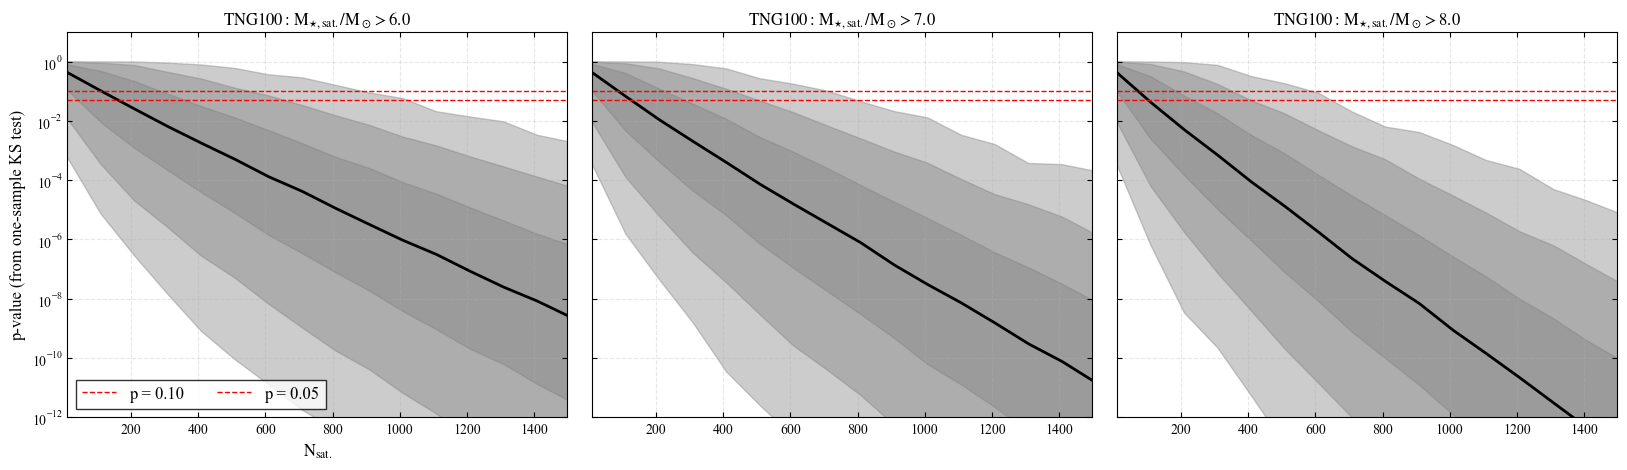

In [1547]:


Ns = np.arange(10, 2000, 100)
pval_median = np.array(pval_median_1e6)
pval_lo = np.array(pval_lo1_1e6)
pval_hi = np.array(pval_hi1_1e6)

fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharex=True, sharey=True)

ax[0].tick_params(which='both',direction='in',top=True,right=True)
ax[1].tick_params(which='both',direction='in',top=True,right=True)
ax[2].tick_params(which='both',direction='in',top=True,right=True)

ax[0].fill_between(Ns,pval_lo3_1e6,pval_hi3_1e6,color='gray',alpha=0.4)#,label=r'$\pm1\sigma$')
ax[0].fill_between(Ns,pval_lo2_1e6,pval_hi2_1e6,color='gray',alpha=0.4)#,label=r'$\pm2\sigma$')
ax[0].fill_between(Ns,pval_lo1_1e6,pval_hi1_1e6,color='gray',alpha=0.4)#,label=r'$\pm3\sigma$')
ax[0].plot(Ns,pval_median_1e6,color='black',lw=2)#,label='Median KS p-value')

ax[1].fill_between(Ns,pval_lo3_1e7,pval_hi3_1e7,color='gray',alpha=0.4)#,label=r'$\pm1\sigma$')
ax[1].fill_between(Ns,pval_lo2_1e7,pval_hi2_1e7,color='gray',alpha=0.4)#,label=r'$\pm2\sigma$')
ax[1].fill_between(Ns,pval_lo1_1e7,pval_hi1_1e7,color='gray',alpha=0.4)#,label=r'$\pm3\sigma$')
ax[1].plot(Ns,pval_median_1e7,color='black',lw=2)#,label='Median KS p-value')

ax[2].fill_between(Ns,pval_lo3_1e8,pval_hi3_1e8,color='gray',alpha=0.4)#,label=r'$\pm1\sigma$')
ax[2].fill_between(Ns,pval_lo2_1e8,pval_hi2_1e8,color='gray',alpha=0.4)#,label=r'$\pm2\sigma$')
ax[2].fill_between(Ns,pval_lo1_1e8,pval_hi1_1e8,color='gray',alpha=0.4)#,label=r'$\pm3\sigma$')
ax[2].plot(Ns,pval_median_1e8,color='black',lw=2)#,label='Median KS p-value')

ax[0].axhline(0.10, color='r', ls='--', lw=1,label=r'p = 0.10')
ax[0].axhline(0.05, color='r', ls='--', lw=1,label=r'p = 0.05')
ax[1].axhline(0.10, color='r', ls='--', lw=1,label=r'p = 0.10')
ax[1].axhline(0.05, color='r', ls='--', lw=1,label=r'p = 0.05')
ax[2].axhline(0.10, color='r', ls='--', lw=1,label=r'p = 0.10')
ax[2].axhline(0.05, color='r', ls='--', lw=1,label=r'p = 0.05')

ax[0].set_xlim(10,1500)
ax[0].set_ylim(1e-12,1e1)

ax[0].set_yscale('log')

ax[0].set_xlabel(r'$\mathrm{N_{sat.}}$',fontsize=12)
ax[0].set_ylabel('p-value (from one-sample KS test)',fontsize=12)
ax[0].legend(loc='lower left', fancybox=False,edgecolor='k',ncol=3,fontsize=12)
ax[0].grid(True, which='both', alpha=0.3,ls='--')
ax[1].grid(True, which='both', alpha=0.3,ls='--')
ax[2].grid(True, which='both', alpha=0.3,ls='--')

ax[0].set_title(r'$\mathrm{TNG100:\,M_{\star,sat.}/M_\odot>6.0}$')
ax[1].set_title(r'$\mathrm{TNG100:\,M_{\star,sat.}/M_\odot>7.0}$')
ax[2].set_title(r'$\mathrm{TNG100:\,M_{\star,sat.}/M_\odot>8.0}$')

plt.subplots_adjust(wspace=0.05)
plt.show()


### Two-Sample KS-Test (+ One-Sample KS-Test for Q and SF subsample)

In [59]:
#elves_quenched = elves_quenched.to_numpy()
elves_90_correct = np.array(elves_90_correct)

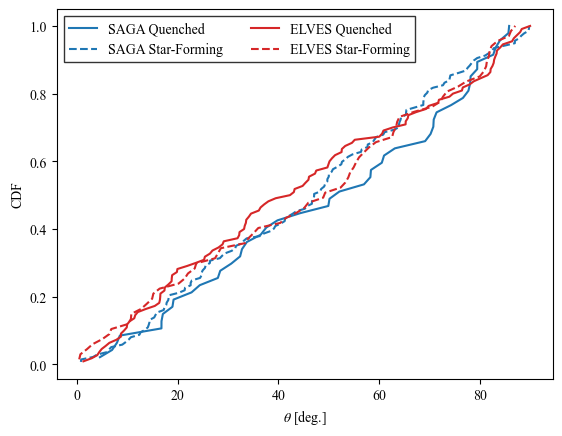

In [60]:
saga_q = (saga_quenched == 1)
saga_sf = (saga_quenched == 0)
sort_saga_q = np.argsort(saga_90[saga_q])
sort_saga_sf = np.argsort(saga_90[saga_sf])

#sort_elves = np.argsort(np.array(elves_90_correct))

elves_q = (elves_quenched == 1)
elves_sf = (elves_quenched == 0)
sort_elves_q = np.argsort(elves_90_correct[elves_q])
sort_elves_sf = np.argsort(elves_90_correct[elves_sf])

cdf_saga_q = np.arange(1, len(saga_90[saga_q])+1) / len(saga_90[saga_q])
cdf_saga_sf = np.arange(1, len(saga_90[saga_sf])+1) / len(saga_90[saga_sf])

cdf_elves_q = np.arange(1, len(elves_90_correct[elves_q])+1) / len(elves_90_correct[elves_q])
cdf_elves_sf = np.arange(1, len(elves_90_correct[elves_sf])+1) / len(elves_90_correct[elves_sf])

plt.plot(saga_90[saga_q][sort_saga_q], cdf_saga_q, color=saga_line, ls = '-', label='SAGA Quenched')
plt.plot(saga_90[saga_sf][sort_saga_sf], cdf_saga_sf, color=saga_line, ls = '--', label='SAGA Star-Forming')

plt.plot(elves_90_correct[elves_q][sort_elves_q], cdf_elves_q, color=elves_line, ls = '-', label='ELVES Quenched')
plt.plot(elves_90_correct[elves_sf][sort_elves_sf], cdf_elves_sf, color=elves_line, ls = '--', label='ELVES Star-Forming')

# plot isotropic expectation
#theta_ref = np.linspace(0, 90, 200)
#cdf_iso = theta_ref / 90.0
#plt.plot(theta_ref, cdf_iso, color='black', ls='-', lw=2)

plt.xlabel(r'$\theta$ [deg.]')
plt.ylabel('CDF')
plt.legend(fancybox=False,edgecolor='k',ncol=2)
plt.show()

In [61]:
# two-sample KS test for SAGA/ELVES

print('SAGA:')
print(f'Q against Uniform Dist.: {stats.kstest(saga_90[saga_q][sort_saga_q], "uniform",args=(0, 90))}')
print(f'SF against Uniform Dist.: {stats.kstest(saga_90[saga_sf][sort_saga_sf], "uniform",args=(0, 90))}')
print(' ')
print('ELVES:')
print(f'Q against Uniform Dist.: {stats.kstest(elves_90_correct[elves_q][sort_elves_q], "uniform",args=(0, 90))}')
print(f'SF against Uniform Dist.: {stats.kstest(elves_90_correct[elves_sf][sort_elves_sf], "uniform",args=(0, 90))}')

#print(f'ELVES Q vs. SF: {stats.ks_2samp(elves_90_correct[elves_q][sort_elves_q], elves_90_correct[elves_sf][sort_elves_sf])}')

SAGA:
Q against Uniform Dist.: KstestResult(statistic=0.12995988169075923, pvalue=0.3730709549029734, statistic_location=69.14319786280663, statistic_sign=-1)
SF against Uniform Dist.: KstestResult(statistic=0.0573256950524383, pvalue=0.7367052295973298, statistic_location=12.38558992698222, statistic_sign=-1)
 
ELVES:
Q against Uniform Dist.: KstestResult(statistic=0.06149476401481241, pvalue=0.7763165106413458, statistic_location=34.55638032957597, statistic_sign=1)
SF against Uniform Dist.: KstestResult(statistic=0.0742161155066795, pvalue=0.8275286414006263, statistic_location=52.35109218664593, statistic_sign=-1)


In [62]:
# two-sample KS test for SAGA/ELVES

print(f'SAGA Q vs. SF: {stats.ks_2samp(saga_90[saga_q][sort_saga_q], saga_90[saga_sf][sort_saga_sf])}')
print(' ')
print(f'ELVES Q vs. SF: {stats.ks_2samp(elves_90_correct[elves_q][sort_elves_q], elves_90_correct[elves_sf][sort_elves_sf])}')

SAGA Q vs. SF: KstestResult(statistic=0.15732256561577884, pvalue=0.31115086712769086, statistic_location=69.08886787710827, statistic_sign=-1)
 
ELVES Q vs. SF: KstestResult(statistic=0.12306648575305291, pvalue=0.5040314649247061, statistic_location=53.27694524733624, statistic_sign=1)


TNG100-1, Msat > 1e8: KstestResult(statistic=0.05721080669710807, pvalue=0.020768238857600325, statistic_location=21.221246491061947, statistic_sign=-1)
Q against Uniform Dist.: KstestResult(statistic=0.046279172334670104, pvalue=0.025819616265177703, statistic_location=40.656303061308265, statistic_sign=1)
SF against Uniform Dist.: KstestResult(statistic=0.07974925033473043, pvalue=1.4588953404244598e-12, statistic_location=20.23352637398385, statistic_sign=1)
 
TNG100-1, Msat > 1e7: KstestResult(statistic=0.06278026905829596, pvalue=2.3051763967162916e-06, statistic_location=23.373756643559148, statistic_sign=-1)
Q against Uniform Dist.: KstestResult(statistic=0.035450802730298714, pvalue=0.00011799273127772437, statistic_location=28.64948986607436, statistic_sign=1)
SF against Uniform Dist.: KstestResult(statistic=0.09059204443526375, pvalue=9.562518355706544e-23, statistic_location=24.82557570614337, statistic_sign=1)
 
TNG100-1, Msat > 1e6: KstestResult(statistic=0.074985836533180

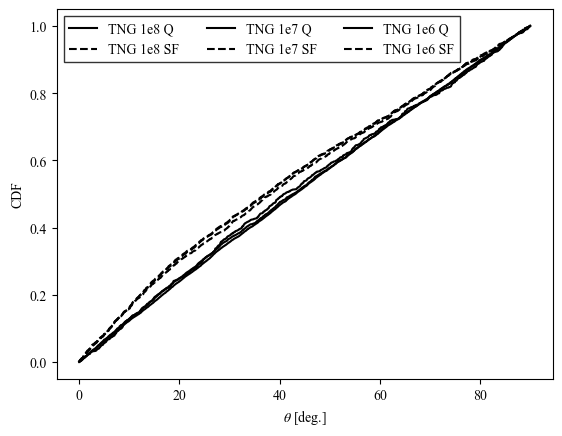

In [67]:
# TNG100-1 plot

# 1e8

df_tng100_1e8 = pd.read_csv("satellite_1e8/centrals_satellites_tng100_mstar_1e8.csv")
df_tng100_host_mh_1e8 = pd.read_csv("satellite_1e8/centrals_satellites_tng100_host_mh_1e8.csv")
df_tng100_alpha_1e8 = pd.read_csv("satellite_1e8/centrals_satellites_tng100_alpha_1e8.csv")
tng100_sfr_info_1e8 = pd.read_csv("satellite_1e8/tng100_sfr_info_1e8.csv")

index = (df_tng100_host_mh_1e8['host_mh'] > 12) & (df_tng100_host_mh_1e8['host_mh'] < 12.5)
sfr_interp = np.log10((10**(0.75*tng100_sfr_info_1e8['mstar'][index]-7.5))/10)
index_sf = (10**sfr_interp <= tng100_sfr_info_1e8['sfr'][index])
index_q = (10**sfr_interp > tng100_sfr_info_1e8['sfr'][index])
q_sf_array = np.ones(len(tng100_sfr_info_1e8['host_mh'][index]))
q_sf_array[index_sf] = 0.

angles_all = df_tng100_alpha_1e8.iloc[:, 0]
angles_q  = angles_all[index][index_q]
angles_sf = angles_all[index][index_sf]
angles_q_sorted  = np.sort(angles_q)
angles_sf_sorted = np.sort(angles_sf)
cdf_q  = np.arange(1, len(angles_q_sorted)  + 1) / len(angles_q_sorted)
cdf_sf = np.arange(1, len(angles_sf_sorted) + 1) / len(angles_sf_sorted)
plt.plot(angles_q_sorted,  cdf_q,  color='black', ls='-',  label='TNG 1e8 Q')
plt.plot(angles_sf_sorted, cdf_sf, color='black', ls='--', label='TNG 1e8 SF')

# two-sample KS test
print(f'TNG100-1, Msat > 1e8: {stats.ks_2samp(angles_q_sorted, angles_sf_sorted)}')
# one-sample KS test
print(f'Q against Uniform Dist.: {stats.kstest(angles_q_sorted, "uniform",args=(0, 90))}')
print(f'SF against Uniform Dist.: {stats.kstest(angles_sf_sorted, "uniform",args=(0, 90))}')
print(' ')

# 1e7

df_tng100_1e7 = pd.read_csv("satellite_1e7/centrals_satellites_tng100_mstar_1e7.csv")
df_tng100_host_mh_1e7 = pd.read_csv("satellite_1e7/centrals_satellites_tng100_host_mh_1e7.csv")
df_tng100_alpha_1e7 = pd.read_csv("satellite_1e7/centrals_satellites_tng100_alpha_1e7.csv")
tng100_sfr_info_1e7 = pd.read_csv("satellite_1e7/tng100_sfr_info_1e7.csv")

index = (df_tng100_host_mh_1e7['host_mh'] > 12) & (df_tng100_host_mh_1e7['host_mh'] < 12.5)
sfr_interp = np.log10((10**(0.75*tng100_sfr_info_1e7['mstar'][index]-7.5))/10)
index_sf = (10**sfr_interp <= tng100_sfr_info_1e7['sfr'][index])
index_q = (10**sfr_interp > tng100_sfr_info_1e7['sfr'][index])
q_sf_array = np.ones(len(tng100_sfr_info_1e7['host_mh'][index]))
q_sf_array[index_sf] = 0.

angles_all = df_tng100_alpha_1e7.iloc[:, 0]
angles_q  = angles_all[index][index_q]
angles_sf = angles_all[index][index_sf]
angles_q_sorted  = np.sort(angles_q)
angles_sf_sorted = np.sort(angles_sf)
cdf_q  = np.arange(1, len(angles_q_sorted)  + 1) / len(angles_q_sorted)
cdf_sf = np.arange(1, len(angles_sf_sorted) + 1) / len(angles_sf_sorted)
plt.plot(angles_q_sorted,  cdf_q,  color='black', ls='-',  label='TNG 1e7 Q')
plt.plot(angles_sf_sorted, cdf_sf, color='black', ls='--', label='TNG 1e7 SF')

# two-sample KS test
print(f'TNG100-1, Msat > 1e7: {stats.ks_2samp(angles_q_sorted, angles_sf_sorted)}')
# one-sample KS test
print(f'Q against Uniform Dist.: {stats.kstest(angles_q_sorted, "uniform",args=(0, 90))}')
print(f'SF against Uniform Dist.: {stats.kstest(angles_sf_sorted, "uniform",args=(0, 90))}')
print(' ')

# 1e6

df_tng100_1e6 = pd.read_csv("satellite_1e6/centrals_satellites_tng100_mstar_1e6.csv")
df_tng100_host_mh_1e6 = pd.read_csv("satellite_1e6/centrals_satellites_tng100_host_mh_1e6.csv")
df_tng100_alpha_1e6 = pd.read_csv("satellite_1e6/centrals_satellites_tng100_alpha_1e6.csv")
tng100_sfr_info_1e6 = pd.read_csv("satellite_1e6/tng100_sfr_info_1e6.csv")

index = (df_tng100_host_mh_1e6['host_mh'] > 12) & (df_tng100_host_mh_1e6['host_mh'] < 12.5)
sfr_interp = np.log10((10**(0.75*tng100_sfr_info_1e6['mstar'][index]-7.5))/10)
index_sf = (10**sfr_interp <= tng100_sfr_info_1e6['sfr'][index])
index_q = (10**sfr_interp > tng100_sfr_info_1e6['sfr'][index])
q_sf_array = np.ones(len(tng100_sfr_info_1e6['host_mh'][index]))
q_sf_array[index_sf] = 0.

angles_all = df_tng100_alpha_1e6.iloc[:, 0]
angles_q  = angles_all[index][index_q]
angles_sf = angles_all[index][index_sf]
angles_q_sorted  = np.sort(angles_q)
angles_sf_sorted = np.sort(angles_sf)
cdf_q  = np.arange(1, len(angles_q_sorted)  + 1) / len(angles_q_sorted)
cdf_sf = np.arange(1, len(angles_sf_sorted) + 1) / len(angles_sf_sorted)
plt.plot(angles_q_sorted,  cdf_q,  color='black', ls='-',  label='TNG 1e6 Q')
plt.plot(angles_sf_sorted, cdf_sf, color='black', ls='--', label='TNG 1e6 SF')

# two-sample KS test
print(f'TNG100-1, Msat > 1e6: {stats.ks_2samp(angles_q_sorted, angles_sf_sorted)}')
# one-sample KS test
print(f'Q against Uniform Dist.: {stats.kstest(angles_q_sorted, "uniform",args=(0, 90))}')
print(f'SF against Uniform Dist.: {stats.kstest(angles_sf_sorted, "uniform",args=(0, 90))}')
print(' ')

plt.xlabel(r'$\theta$ [deg.]')
plt.ylabel('CDF')
plt.legend(fancybox=False,edgecolor='k',ncol=3)
plt.show()

## MCMC fit: 

In [68]:
def boostrap_90(data,sf_index,q_index,N):
    
    bins = 18 # same as boostrap function
    dphi = 90/bins/2
    n_bootstrap = N  # number of bootstrap resamples

    # arrays to hold bootstrapped quenched fractions
    boot_fq = np.zeros((n_bootstrap, bins))

    # loop over bootstrap resamples
    for i in range(n_bootstrap):

        sf_sample = data.loc[sf_index].sample(frac=1, replace=True)
        q_sample  = data.loc[q_index].sample(frac=1, replace=True)
        
        g_N_sf, _ = np.histogram(sf_sample['alpha'],density=False, range=[0,90], bins=bins)
        g_N_q, _  = np.histogram(q_sample['alpha'],density=False, range=[0,90], bins=bins)

        with np.errstate(divide="ignore", invalid="ignore"):
            fq = g_N_q / (g_N_q + g_N_sf)
        fq[np.isnan(fq)] = 0.0  # handle empty bins
        
        boot_fq[i] = fq
    
    fq_mean = np.nanmean(boot_fq, axis=0)
    fq_std = np.nanstd(boot_fq, axis=0)

    return fq_mean, fq_std


In [69]:
# load TNG100 data

df_tng100 = pd.read_csv("satellite_1e8/centrals_satellites_tng100_mstar_1e8.csv")
df_tng100_host_mh = pd.read_csv("satellite_1e8/centrals_satellites_tng100_host_mh_1e8.csv")
df_tng100_alpha = pd.read_csv("satellite_1e8/centrals_satellites_tng100_alpha_1e8.csv")
tng100_sfr_info = pd.read_csv("satellite_1e8/tng100_sfr_info_1e8.csv")

In [70]:
# boostrap TNG100 data 

index = (df_tng100_host_mh['host_mh'] > 12) & (df_tng100_host_mh['host_mh'] < 12.5)

sfr_interp = np.log10((10**(0.75*tng100_sfr_info['mstar'][index]-7.5))/10)

index_sf = (10**sfr_interp <= tng100_sfr_info['sfr'][index])
index_q = (10**sfr_interp > tng100_sfr_info['sfr'][index])

q_sf_array = np.ones(len(tng100_sfr_info['host_mh'][index]))
q_sf_array[index_sf] = 0.

fq_mean_1e8, fq_std_1e8 = boostrap_90(tng100_sfr_info[index],index_sf,index_q,10000)

# load 1e6 and 1e7 data 

df_tng100 = pd.read_csv("satellite_1e7/centrals_satellites_tng100_mstar_1e7.csv")
df_tng100_host_mh = pd.read_csv("satellite_1e7/centrals_satellites_tng100_host_mh_1e7.csv")
df_tng100_alpha = pd.read_csv("satellite_1e7/centrals_satellites_tng100_alpha_1e7.csv")
tng100_sfr_info = pd.read_csv("satellite_1e7/tng100_sfr_info_1e7.csv")

index = (df_tng100_host_mh['host_mh'] > 12) & (df_tng100_host_mh['host_mh'] < 12.5)
sfr_interp = np.log10((10**(0.75*tng100_sfr_info['mstar'][index]-7.5))/10)
index_sf = (10**sfr_interp <= tng100_sfr_info['sfr'][index])
index_q = (10**sfr_interp > tng100_sfr_info['sfr'][index])
q_sf_array = np.ones(len(tng100_sfr_info['host_mh'][index]))
q_sf_array[index_sf] = 0.
fq_mean_1e7, fq_std_1e7 = boostrap_90(tng100_sfr_info[index],index_sf,index_q,10000)

df_tng100 = pd.read_csv("satellite_1e6/centrals_satellites_tng100_mstar_1e6.csv")
df_tng100_host_mh = pd.read_csv("satellite_1e6/centrals_satellites_tng100_host_mh_1e6.csv")
df_tng100_alpha = pd.read_csv("satellite_1e6/centrals_satellites_tng100_alpha_1e6.csv")
tng100_sfr_info = pd.read_csv("satellite_1e6/tng100_sfr_info_1e6.csv")

index = (df_tng100_host_mh['host_mh'] > 12) & (df_tng100_host_mh['host_mh'] < 12.5)
sfr_interp = np.log10((10**(0.75*tng100_sfr_info['mstar'][index]-7.5))/10)
index_sf = (10**sfr_interp <= tng100_sfr_info['sfr'][index])
index_q = (10**sfr_interp > tng100_sfr_info['sfr'][index])
q_sf_array = np.ones(len(tng100_sfr_info['host_mh'][index]))
q_sf_array[index_sf] = 0.
fq_mean_1e6, fq_std_1e6 = boostrap_90(tng100_sfr_info[index],index_sf,index_q,10000)

In [71]:
def calculate_log_likelihood(theta, bin_centers, f_q, sigma_i):

    a, b, f = theta

    # Compute total variance
    s_i = sigma_i**2 + (np.exp(f))**2

    # Model prediction
    f_model = a + b * np.cos(2 * np.radians(bin_centers))

    # Residuals and log-likelihood
    residuals = (f_q - f_model)**2 / s_i
    log_likelihood = -0.5 * np.sum(residuals + np.log(2 * np.pi * s_i))
    
    return log_likelihood

def log_prior(theta):
    a, b, f = theta
    if 0 < a < 1 and -1 < b < 1 and -10 < f < 2:
        return 0.0
    return -np.inf

def calculate_log_probability(theta, bin_centers, f_q, sigma_i):
    
    log_prior_val = log_prior(theta)
    if not np.isfinite(log_prior_val):
        return -np.inf
    log_likelihood = calculate_log_likelihood(theta, bin_centers, f_q, sigma_i)
    return log_prior_val + log_likelihood

In [73]:
# 1e6

# MCMC Configuration

n_walkers_full = 20
n_dim_full = 3 
initial_guess_full = [0.7, 0.025, -3]
pos_full = np.array(initial_guess_full) + np.random.randn(n_walkers_full, n_dim_full) * 1e-2

# Setting up the sampler
sampler_full = emcee.EnsembleSampler(n_walkers_full, n_dim_full, calculate_log_probability,args=(angle_array, fq_mean_1e6, fq_std_1e6))

# Run MCMC
n_steps = 10_000
sampler_full.run_mcmc(pos_full, n_steps, progress=True)

# Post-Processing
samples_full = sampler_full.get_chain(discard=1000, flat=True)
log_prob_full = sampler_full.get_log_prob(discard=1000, flat=True)

mean_params_tng100_all = np.mean(samples_full, axis=0)
std_params_tng100_all = np.std(samples_full, axis=0)
a_1e6, b_1e6, f_1e6 = mean_params_tng100_all
a_1e6_std, b_1e6_std, f_1e6_std = std_params_tng100_all

# 1e7

# MCMC Configuration

n_walkers_full = 20
n_dim_full = 3 
initial_guess_full = [0.7, 0.025, -3]
pos_full = np.array(initial_guess_full) + np.random.randn(n_walkers_full, n_dim_full) * 1e-2

# Setting up the sampler
sampler_full = emcee.EnsembleSampler(n_walkers_full, n_dim_full, calculate_log_probability,args=(angle_array, fq_mean_1e7, fq_std_1e7))

# Run MCMC
n_steps = 10_000
sampler_full.run_mcmc(pos_full, n_steps, progress=True)

# Post-Processing
samples_full = sampler_full.get_chain(discard=1000, flat=True)
log_prob_full = sampler_full.get_log_prob(discard=1000, flat=True)

mean_params_tng100_all = np.mean(samples_full, axis=0)
std_params_tng100_all = np.std(samples_full, axis=0)
a_1e7, b_1e7, f_1e7 = mean_params_tng100_all
a_1e7_std, b_1e7_std, f_1e7_std = std_params_tng100_all

# 1e8

# MCMC Configuration

n_walkers_full = 20
n_dim_full = 3 
initial_guess_full = [0.7, 0.025, -3]
pos_full = np.array(initial_guess_full) + np.random.randn(n_walkers_full, n_dim_full) * 1e-2

# Setting up the sampler
sampler_full = emcee.EnsembleSampler(n_walkers_full, n_dim_full, calculate_log_probability,args=(angle_array, fq_mean_1e8, fq_std_1e8))

# Run MCMC
n_steps = 10_000
sampler_full.run_mcmc(pos_full, n_steps, progress=True)

# Post-Processing
samples_full = sampler_full.get_chain(discard=1000, flat=True)
log_prob_full = sampler_full.get_log_prob(discard=1000, flat=True)

mean_params_tng100_all = np.mean(samples_full, axis=0)
std_params_tng100_all = np.std(samples_full, axis=0)
a_1e8, b_1e8, f_1e8 = mean_params_tng100_all
a_1e8_std, b_1e8_std, f_1e8_std = std_params_tng100_all

100%|████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1797.22it/s]


In [74]:
# repeat for ELVES and SAGA surveys 

def bootstrap_90_observational_binned(x, y, N, bins=18, angle_range=(0, 90)):

    x = np.asarray(x)
    y = np.asarray(y, dtype=float)

    bin_edges = np.linspace(angle_range[0], angle_range[1], bins + 1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    boot_fq = np.full((N, bins), np.nan)

    # loop over bins
    for j in range(bins):
        in_bin = (x >= bin_edges[j]) & (x < bin_edges[j + 1])
        y_bin = y[in_bin]
        n_bin = len(y_bin)

        if n_bin < 2:
            continue  # leave NaN

        # bootstrap galaxies *within this bin*
        for i in range(N):
            idx = np.random.choice(n_bin, size=n_bin, replace=True)
            boot_fq[i, j] = np.mean(y_bin[idx])

    fq_mean = np.nanmean(boot_fq, axis=0)
    fq_std  = np.nanstd(boot_fq, axis=0)

    return bin_centers, fq_mean, fq_std

def bootstrap_90_observational_binned(x, y, N=10000, bins=18, angle_range=(0, 90)):
    """
    Parameters
    ----------
    x : array-like
        Galaxy angles (0-90 deg)
    y : array-like
        Quantity to average per galaxy (e.g., 1 for quenched, 0 for SF)
    N : int
        Number of bootstrap resamples
    bins : int
        Number of bins in angle
    angle_range : tuple
        Min and max of angle (default: 0-90 deg)
    
    Returns
    -------
    bin_centers : array
        Centers of bins
    fq_mean : array
        Mean fraction per bin over all bootstraps
    fq_std : array
        1-sigma uncertainty per bin from bootstrap
    """

    x = np.asarray(x)
    y = np.asarray(y, dtype=float)

    bin_edges = np.linspace(angle_range[0], angle_range[1], bins + 1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    boot_fq = np.full((N, bins), np.nan)

    n_gal = len(x)

    for i in range(N):
        # bootstrap galaxies *across the full sample*
        idx = np.random.choice(n_gal, size=n_gal, replace=True)
        x_boot = x[idx]
        y_boot = y[idx]

        # histogram per bin
        for j in range(bins):
            in_bin = (x_boot >= bin_edges[j]) & (x_boot < bin_edges[j + 1])
            y_bin = y_boot[in_bin]
            if len(y_bin) > 0:
                boot_fq[i, j] = np.mean(y_bin)
            else:
                boot_fq[i, j] = np.nan  # empty bin

    fq_mean = np.nanmean(boot_fq, axis=0)
    fq_std = np.nanstd(boot_fq, axis=0)

    return bin_centers, fq_mean, fq_std

    
x = saga_90.copy()
y = saga_quenched.copy()

bin_centers, fq_mean_saga, fq_std_saga = bootstrap_90_observational_binned(x, y, N=10000)

elves_90_correct = []
for i in range(len(elves_90)):
    elves_90_correct.append(elves_90[i][0])
x = np.array(elves_90_correct)
y = np.array(elves_quenched)

bin_centers, fq_mean_elves, fq_std_elves = bootstrap_90_observational_binned(x, y, N=10000)

In [75]:
# re-fit SAGA and ELVES data with updated boostrapping 

# SAGA

# MCMC Configuration

n_walkers_full = 20
n_dim_full = 3 
initial_guess_full = [0.7, 0.025, -3]
pos_full = np.array(initial_guess_full) + np.random.randn(n_walkers_full, n_dim_full) * 1e-2

# Setting up the sampler
sampler_full = emcee.EnsembleSampler(n_walkers_full, n_dim_full, calculate_log_probability,args=(angle_array, fq_mean_saga, fq_std_saga))

# Run MCMC
n_steps = 10_000
sampler_full.run_mcmc(pos_full, n_steps, progress=True)

# Post-Processing
samples_full = sampler_full.get_chain(discard=1000, flat=True)
log_prob_full = sampler_full.get_log_prob(discard=1000, flat=True)

mean_params_tng100_all = np.mean(samples_full, axis=0)
std_params_tng100_all = np.std(samples_full, axis=0)
a_saga, b_saga, f_saga = mean_params_tng100_all
a_saga_std, b_saga_std, f_saga_std = std_params_tng100_all

# ELVES 

# MCMC Configuration

n_walkers_full = 20
n_dim_full = 3 
initial_guess_full = [0.7, 0.025, -3]
pos_full = np.array(initial_guess_full) + np.random.randn(n_walkers_full, n_dim_full) * 1e-2

# Setting up the sampler
sampler_full = emcee.EnsembleSampler(n_walkers_full, n_dim_full, calculate_log_probability,args=(angle_array, fq_mean_elves, fq_std_elves))

# Run MCMC
n_steps = 10_000
sampler_full.run_mcmc(pos_full, n_steps, progress=True)

# Post-Processing
samples_full = sampler_full.get_chain(discard=1000, flat=True)
log_prob_full = sampler_full.get_log_prob(discard=1000, flat=True)

mean_params_tng100_all = np.mean(samples_full, axis=0)
std_params_tng100_all = np.std(samples_full, axis=0)
a_elves, b_elves, f_elves = mean_params_tng100_all
a_elves_std, b_elves_std, f_elves_std = std_params_tng100_all

100%|████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1800.00it/s]


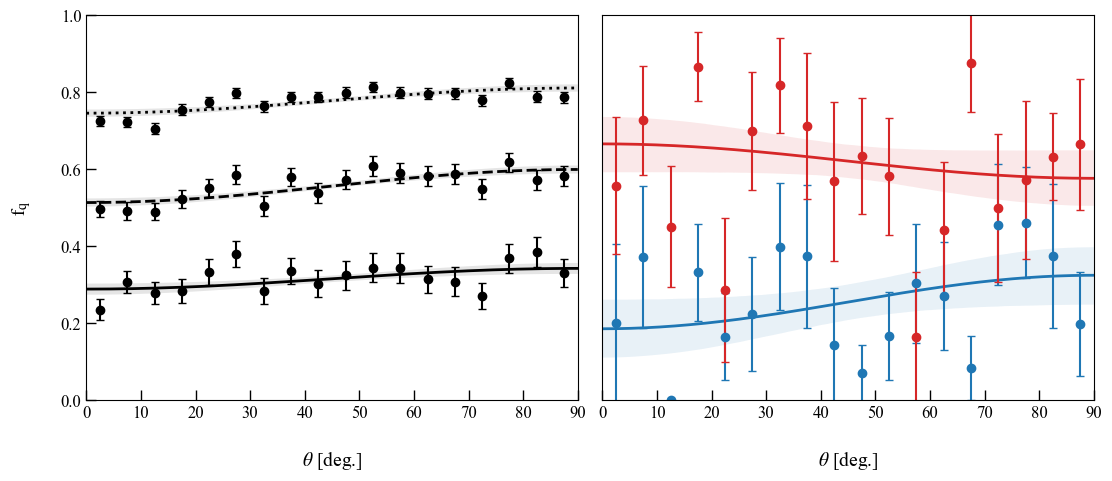

In [76]:
# New high-contrast colors
saga_line = '#1f77b4'
saga_fill = '#aec7e8'
elves_line = '#d62728'
elves_fill = '#ff9896'

fig, (ax_hist,ax_hist2) = plt.subplots(1, 2, figsize=(13, 5))

# SDSS, TNG, SMDPL (from Michael)

#sdss_fq = np.loadtxt('../../sdss/figure1/sdss_fq.txt')
#tng100_fq = np.loadtxt('../../sdss/figure1/tng100_fq.txt')
#smdpl_fq = np.loadtxt('../../sdss/figure1/smdpl_fq.txt')

sdss_hist = sdss_number_count / np.sum(sdss_number_count) / 5
tng_hist  = tng100_number_count / np.sum(tng100_number_count) / 5
tng_hist_1e7  = tng100_number_count_1e7 / np.sum(tng100_number_count_1e7) / 5
tng_hist_1e6  = tng100_number_count_1e6 / np.sum(tng100_number_count_1e6) / 5
smdpl_hist = smdpl_number_count / np.sum(smdpl_number_count) / 5
bin_width = np.diff(angle_array).mean()
edges = np.concatenate([angle_array - bin_width/2,[angle_array[-1] + bin_width/2]])

ax_hist.errorbar(angle_array, fq_mean_1e8, yerr=fq_std_1e8,fmt='o', color='black', mfc='black', mec='black', mew=1,capsize=3)
ax_hist.errorbar(angle_array, fq_mean_1e7, yerr=fq_std_1e7,fmt='o', color='black', mfc='black', mec='black', mew=1,capsize=3)
ax_hist.errorbar(angle_array, fq_mean_1e6, yerr=fq_std_1e6,fmt='o', color='black', mfc='black', mec='black', mew=1,capsize=3)

x = np.linspace(0,np.pi/2,1000)
ax_hist.plot((x*u.rad).to('degree'),a_1e6 + b_1e6 * np.cos(2 * x),color='black', lw=2,ls=':')
ax_hist.plot((x*u.rad).to('degree'),a_1e7 + b_1e7 * np.cos(2 * x),color='black', lw=2,ls='--')
ax_hist.plot((x*u.rad).to('degree'),a_1e8 + b_1e8 * np.cos(2 * x),color='black', lw=2,ls='-')

n_mc = 10000
a_samp = np.random.normal(a_1e6, a_1e6_std, n_mc)
b_samp = np.random.normal(b_1e6, b_1e6_std, n_mc)
cos2x = np.cos(2 * x)
y_mc = a_samp[:, None] + b_samp[:, None] * cos2x[None, :]
y_med   = np.percentile(y_mc, 50, axis=0)
y_low   = np.percentile(y_mc, 16, axis=0)
y_high  = np.percentile(y_mc, 84, axis=0)
theta_deg = (x * u.rad).to('degree').value
ax_hist.fill_between(theta_deg,y_low,y_high,color='k',alpha=0.1,edgecolor=None)

n_mc = 10000
a_samp = np.random.normal(a_1e7, a_1e7_std, n_mc)
b_samp = np.random.normal(b_1e7, b_1e7_std, n_mc)
cos2x = np.cos(2 * x)
y_mc = a_samp[:, None] + b_samp[:, None] * cos2x[None, :]
y_med   = np.percentile(y_mc, 50, axis=0)
y_low   = np.percentile(y_mc, 16, axis=0)
y_high  = np.percentile(y_mc, 84, axis=0)
theta_deg = (x * u.rad).to('degree').value
ax_hist.fill_between(theta_deg,y_low,y_high,color='k',alpha=0.1,edgecolor=None)

n_mc = 10000
a_samp = np.random.normal(a_1e8, a_1e8_std, n_mc)
b_samp = np.random.normal(b_1e8, b_1e8_std, n_mc)
cos2x = np.cos(2 * x)
y_mc = a_samp[:, None] + b_samp[:, None] * cos2x[None, :]
y_med   = np.percentile(y_mc, 50, axis=0)
y_low   = np.percentile(y_mc, 16, axis=0)
y_high  = np.percentile(y_mc, 84, axis=0)
theta_deg = (x * u.rad).to('degree').value
ax_hist.fill_between(theta_deg,y_low,y_high,color='k',alpha=0.1,edgecolor=None)

# SAGA 

total_N_saga = len(saga_quenched)
quench_f_saga = np.sum(saga_quenched) / total_N_saga
a_saga, b_central_saga, b_err_saga = np.mean(saga_quenched), 0.03, 0.07

theta_deg_saga = np.linspace(0, 360, 1000)
signal_lower_saga = a_saga + b_central_saga * np.cos(2 * np.radians(theta_deg_saga)) - b_err_saga
signal_upper_saga = a_saga + b_central_saga * np.cos(2 * np.radians(theta_deg_saga)) + b_err_saga

theta_mapped_saga = map_to_0_90(theta_deg_saga)
sort_idx_saga = np.argsort(theta_mapped_saga)

ax_hist2.errorbar(angle_array, fq_mean_saga, yerr=fq_std_saga,fmt='o', color=saga_line, mfc=saga_line, mec=saga_line, mew=1,capsize=3,label="SAGA")
x = np.linspace(0,np.pi/2,1000)
ax_hist2.plot((x*u.rad).to('degree'),a_saga + b_saga * np.cos(2 * x),color=saga_line, lw=2)

n_mc = 10000
a_samp = np.random.normal(a_saga, a_saga_std, n_mc)
b_samp = np.random.normal(b_saga, b_saga_std, n_mc)
cos2x = np.cos(2 * x)
y_mc = a_samp[:, None] + b_samp[:, None] * cos2x[None, :]
y_med   = np.percentile(y_mc, 50, axis=0)
y_low   = np.percentile(y_mc, 16, axis=0)
y_high  = np.percentile(y_mc, 84, axis=0)
theta_deg = (x * u.rad).to('degree').value
ax_hist2.fill_between(theta_deg,y_low,y_high,color=saga_line,alpha=0.1,edgecolor=None)

# ELVES

total_N_elves = len(elves_quenched)
quench_f_elves = np.sum(elves_quenched) / total_N_elves
a_elves, b_central_elves, b_err_elves = elves_mean, 0.09, 0.04

theta_deg_elves = np.linspace(0, 360, 1000)
signal_lower_elves = a_elves + b_central_elves * np.cos(2 * np.radians(theta_deg_elves)) - b_err_elves
signal_upper_elves = a_elves + b_central_elves * np.cos(2 * np.radians(theta_deg_elves)) + b_err_elves

theta_mapped_elves = map_to_0_90(theta_deg_elves)
sort_idx_elves = np.argsort(theta_mapped_elves)

ax_hist2.errorbar(angle_array, fq_mean_elves, yerr=fq_std_elves,fmt='o', color=elves_line, mfc=elves_line, mec=elves_line, mew=1,capsize=3,label="SAGA")
x = np.linspace(0,np.pi/2,1000)
ax_hist2.plot((x*u.rad).to('degree'),a_elves + b_elves * np.cos(2 * x),color=elves_line, lw=2)

n_mc = 10000
a_samp = np.random.normal(a_elves, a_elves_std, n_mc)
b_samp = np.random.normal(b_elves, b_elves_std, n_mc)
cos2x = np.cos(2 * x)
y_mc = a_samp[:, None] + b_samp[:, None] * cos2x[None, :]
y_med   = np.percentile(y_mc, 50, axis=0)
y_low   = np.percentile(y_mc, 16, axis=0)
y_high  = np.percentile(y_mc, 84, axis=0)
theta_deg = (x * u.rad).to('degree').value
ax_hist2.fill_between(theta_deg,y_low,y_high,color=elves_line,alpha=0.1,edgecolor=None)

ax_hist.set_ylabel(r'$\mathrm{f_q}$', fontsize=14, labelpad=20)
ax_hist.set_xlabel(r'$\theta$ [deg.]', fontsize=14, labelpad=20)
ax_hist2.set_xlabel(r'$\theta$ [deg.]', fontsize=14, labelpad=20)

ax_hist.set_xlim(0, 90)
ax_hist2.set_xlim(0, 90)

ax_hist.set_ylim(0, 1)
ax_hist2.set_ylim(0, 1)

ax_hist.tick_params(axis="both", which="major", direction="in", labelsize=12, length=7, width=1)
ax_hist.tick_params(axis="both", which="minor", direction="in", labelsize=12, length=2, width=1)

ax_hist2.tick_params(axis="both", which="major", direction="in", labelsize=12, length=7, width=1)
ax_hist2.tick_params(axis="both", which="minor", direction="in", labelsize=12, length=2, width=1)

ax_hist2.set_yticks([])

plt.subplots_adjust(wspace=0.05)
plt.show()

## BIC/AIC Analysis:

### Interpretation: If the amplitude b = 0, then the sinsoidal function is merely a constant, or the quench fraction. We can therefore ask, how many std away from 0 is the parameter b mean? We find that there is significant overlap in the SAGA and ELVES b parameter. However, there is less overlap in the TNG100-1 subsamples.

In [77]:
# calulate how many std the mean is from 0 (for the parameter b, such that b = 0 is consistent with a st)

n_mc = 100000
b_samp = np.random.normal(b_saga, b_saga_std, n_mc)

#plt.hist(b_samp,bins=100,histtype='step',color='k');

b_mean = np.mean(b_samp)
b_std  = np.std(b_samp)
sigma_significance = np.abs(b_mean / b_std)
print(sigma_significance)

#######

b_samp = np.random.normal(b_elves, b_elves_std, n_mc)

#plt.hist(b_samp,bins=100,histtype='step',color='k');

b_mean = np.mean(b_samp)
b_std  = np.std(b_samp)
sigma_significance = np.abs(b_mean / b_std)
print(sigma_significance)

#######

b_samp = np.random.normal(b_1e8, b_1e8_std, n_mc)

#plt.hist(b_samp,bins=100,histtype='step',color='k');

b_mean = np.mean(b_samp)
b_std  = np.std(b_samp)
sigma_significance = np.abs(b_mean / b_std)
print(sigma_significance)

#######

b_samp = np.random.normal(b_1e7, b_1e7_std, n_mc)

#plt.hist(b_samp,bins=100,histtype='step',color='k');

b_mean = np.mean(b_samp)
b_std  = np.std(b_samp)
sigma_significance = np.abs(b_mean / b_std)
print(sigma_significance)

#######

b_samp = np.random.normal(b_1e6, b_1e6_std, n_mc)

#plt.hist(b_samp,bins=100,histtype='step',color='k');

b_mean = np.mean(b_samp)
b_std  = np.std(b_samp)
sigma_significance = np.abs(b_mean / b_std)
print(sigma_significance)

1.1739024012223869
0.7838275085902834
2.3251248244912897
4.950704396316425
4.183792570013034


In [78]:
# calculate the BIC (and AIC) for the sinusoidal fit versus constant
# be careful of f value -- is this an extra parmameter?

def sinusoid(x, a, b, f):
    
    return a + b * np.cos(2 * x)

def BIC(x_data, y_data, y_err, a_fit, b_fit, f_fit):

    resid = y_data - sinusoid(x_data, a_fit, b_fit, f_fit)
    print(resid)                       
    n = len(y_data)
    k = 2
    logL = -0.5 * np.sum((resid / y_err)**2 + np.log(2*np.pi*y_err**2))
    bic_sin = k * np.log(n) - 2 * logL
    print("BIC Sinudoid Fit =", bic_sin) 
    aic_sin = 2*k - 2*logL
    print("AIC Sinudoid Fit =", aic_sin) 

    resid_const = y_data - np.mean(y_data)
    k_const = 1
    logL_const = -0.5 * np.sum((resid_const / y_err)**2 + np.log(2*np.pi*y_err**2))
    bic_const = k_const * np.log(n) - 2 * logL_const
    print("BIC Constant Fit =", bic_const)
    aic_const = 2*k - 2*logL_const
    print("AIC Constant Fit =", aic_const) 

    print('Delta BIC =',np.abs(bic_const-bic_sin))
    print('Delta AIC =',np.abs(aic_const-aic_sin))
    if bic_const < bic_sin:
        print("From BIC, Constant model preferred")
    else:
        print("From BIC, Sinusoid model preferred")

    if aic_const < aic_sin:
        print("From AIC, Constant model preferred")
    else:
        print("From AIC, Sinusoid model preferred")

print('ELVES:')
BIC(angle_array, fq_mean_elves, fq_std_elves, a_elves, b_elves, f_elves)
print(' ')
print('SAGA:')
BIC(angle_array, fq_mean_saga, fq_std_saga, a_saga, b_saga, f_saga)
print(' ')
print('TNG100-1, > 1e8:')
BIC(angle_array, fq_mean_1e8, fq_std_1e8, a_1e8, b_1e8, f_1e8)
print(' ')
print('TNG100-1, > 1e7:')
BIC(angle_array, fq_mean_1e7, fq_std_1e7, a_1e7, b_1e7, f_1e7)
print(' ')
print('TNG100-1, > 1e6:')
BIC(angle_array, fq_mean_1e6, fq_std_1e6, a_1e6, b_1e6, f_1e6)

ELVES:
[-0.07615539  0.14032332 -0.21464277  0.28564547 -0.35816325  0.07687207
  0.22155317  0.04964239 -0.00860634 -0.01920763 -0.02841873 -0.44175459
 -0.21394678  0.29889651 -0.16124593 -0.02687768  0.01470273  0.01711617]
BIC Sinudoid Fit = 7.06127743686744
AIC Sinudoid Fit = 5.2805339210751105
BIC Constant Fit = -0.5999073817314384
AIC Constant Fit = 0.509720860372397
Delta BIC = 7.661184818598878
Delta AIC = 4.7708130607027135
From BIC, Constant model preferred
From AIC, Constant model preferred
 
SAGA:
[-0.03521531  0.06403515 -0.18655766  0.01474206 -0.05347483 -0.02980004
  0.10470021  0.1825617  -0.17999945 -0.13321574 -0.10469446  0.02614079
  0.07133391 -0.24176225  0.2621704   0.17259966  0.11562485 -0.014618  ]
BIC Sinudoid Fit = nan
AIC Sinudoid Fit = nan
BIC Constant Fit = nan
AIC Constant Fit = nan
Delta BIC = nan
Delta AIC = nan
From BIC, Sinusoid model preferred
From AIC, Sinusoid model preferred
 
TNG100-1, > 1e8:
[-0.07280828 -0.02943918 -0.01034389 -0.05603418  0

/var/folders/g8/yhp4yljs3hnc8p358tbh51680000gn/T/ipykernel_31666/2384875561.py:14: RuntimeWarning: divide by zero encountered in divide
  logL = -0.5 * np.sum((resid / y_err)**2 + np.log(2*np.pi*y_err**2))
/var/folders/g8/yhp4yljs3hnc8p358tbh51680000gn/T/ipykernel_31666/2384875561.py:14: RuntimeWarning: divide by zero encountered in log
  logL = -0.5 * np.sum((resid / y_err)**2 + np.log(2*np.pi*y_err**2))
/var/folders/g8/yhp4yljs3hnc8p358tbh51680000gn/T/ipykernel_31666/2384875561.py:14: RuntimeWarning: invalid value encountered in add
  logL = -0.5 * np.sum((resid / y_err)**2 + np.log(2*np.pi*y_err**2))
/var/folders/g8/yhp4yljs3hnc8p358tbh51680000gn/T/ipykernel_31666/2384875561.py:22: RuntimeWarning: divide by zero encountered in divide
  logL_const = -0.5 * np.sum((resid_const / y_err)**2 + np.log(2*np.pi*y_err**2))
/var/folders/g8/yhp4yljs3hnc8p358tbh51680000gn/T/ipykernel_31666/2384875561.py:22: RuntimeWarning: divide by zero encountered in log
  logL_const = -0.5 * np.sum((resid_co

### Interpretation: Instead of looking at the amplitude b, we can instead ask: How much better of a fit is the sinusoidal function compared to a constant (the mean quench fraction across all angle bins). This can be calculated using both the BIC (penalizes number of paramaeters more) and AIC. We find that all data are better fit with a constant. Supposedly the AIC for the SAGA data is slightly lower for the sinusoid compared to the constant model, but the $\Delta$BIC is 1.15. As a good rule of thumb, > 10 suggests that there is strong evidence.

## Old Code from Nick:

## Alignment Test

In [289]:

#SAGA
theta_deg = np.array(saga_90)  # your folded angles
theta_rad = np.deg2rad(theta_deg)

# Effect size
A_obs = np.mean(np.cos(2 * theta_rad))

# Bootstrap CI
B = 5000
rng = np.random.default_rng(0)
A_boot = []
n = len(theta_rad)

for _ in range(B):
    sample = rng.choice(theta_rad, size=n, replace=True)
    A_boot.append(np.mean(np.cos(2 * sample)))

lo, hi = np.percentile(A_boot, [2.5, 97.5])
print("SAGA")
print(f"<cos(2θ)> = {A_obs:.4f}")
print(f"95% CI: [{lo:.4f}, {hi:.4f}]")


SAGA
<cos(2θ)> = -0.0645
95% CI: [-0.1458, 0.0176]


In [290]:

#ELVES
theta_deg = np.array(elves_90)  # your folded angles
theta_rad = np.deg2rad(theta_deg)

# Effect size
A_obs = np.mean(np.cos(2 * theta_rad))

# Bootstrap CI
B = 5000
rng = np.random.default_rng(0)
A_boot = []
n = len(theta_rad)

for _ in range(B):
    sample = rng.choice(theta_rad, size=n, replace=True)
    A_boot.append(np.mean(np.cos(2 * sample)))

lo, hi = np.percentile(A_boot, [2.5, 97.5])
print("ELVES")
print(f"<cos(2θ)> = {A_obs:.4f}")
print(f"95% CI: [{lo:.4f}, {hi:.4f}]")

ELVES
<cos(2θ)> = 0.0119
95% CI: [-0.0946, 0.1170]


In [293]:
import numpy as np
from scipy.stats import ks_2samp
from scipy.stats import kstest

print("SAGA: Testing Whether Quench and Star forming follow different distribution")
# Inputs:
# theta_deg: folded angles in [0, 90], shape (N,)
# quenched:  1 for quenched, 0 for star-forming, shape (N,)
# host_id:   host identifier per satellite, shape (N,)
theta_deg = np.asarray(saga_90)
quenched  = np.asarray(saga_quenched).astype(int)
host_id   = np.asarray(saga_sats['HOSTID'][radius_limit])


# Split groups
th_q  = theta_deg[quenched == 1]
th_sf = theta_deg[quenched == 0]


print("saga:", kstest(theta_deg, 'uniform' , args=(0, 90)))


# --- (1) Two-sample KS ---
D, p_ks = ks_2samp(th_q, th_sf, alternative='two-sided')
# Extract scalar values to avoid formatting errors
D = D.item() if hasattr(D, 'item') else (float(D[0]) if hasattr(D, '__len__') else D)
p_ks = p_ks.item() if hasattr(p_ks, 'item') else (float(p_ks[0]) if hasattr(p_ks, '__len__') else p_ks)



# --- (2) ΔA effect size ---
c2 = np.cos(2 * np.deg2rad(theta_deg))
A_q  = c2[quenched == 1].mean()
A_sf = c2[quenched == 0].mean()
dA   = A_q - A_sf

print(f"KS: D={D:.4f}, p={p_ks:.3g}")
print(f"A_q={A_q:.4f}, A_sf={A_sf:.4f}, ΔA={dA:.4f}")

# --- (3) 95% CI for ΔA via cluster (host) bootstrap ---
rng = np.random.default_rng(0)
hosts = np.unique(host_id)
B = 5000
dA_boot = []

for _ in range(B):
    boot_hosts = rng.choice(hosts, size=len(hosts), replace=True)
    # keep all satellites belonging to sampled hosts
    mask = np.isin(host_id, boot_hosts)
    c2_b = c2[mask]
    q_b  = quenched[mask]
    if (q_b == 1).any() and (q_b == 0).any():
        dA_boot.append(c2_b[q_b==1].mean() - c2_b[q_b==0].mean())

lo, hi = np.percentile(dA_boot, [2.5, 97.5])
print(f"ΔA 95% CI: [{lo:.4f}, {hi:.4f}]")

# --- (4) Cluster-aware permutation p-values ---
# Permute labels WITHIN each host; preserves per-host clustering and class sizes.
def permute_labels_within_host(q, h, rng):
    q_perm = q.copy()
    for hh in np.unique(h):
        idx = np.where(h == hh)[0]
        q_perm[idx] = rng.permutation(q_perm[idx])
    return q_perm

Bperm = 5000
dA_perm = []
D_perm  = []

for _ in range(Bperm):
    q_p = permute_labels_within_host(quenched, host_id, rng)
    # ΔA under permuted labels
    A_q_p  = c2[q_p==1].mean() if (q_p==1).any() else np.nan
    A_sf_p = c2[q_p==0].mean() if (q_p==0).any() else np.nan
    dA_perm.append(A_q_p - A_sf_p)

    # KS under permuted labels
    th_q_p  = theta_deg[q_p == 1]
    th_sf_p = theta_deg[q_p == 0]
    if len(th_q_p) > 0 and len(th_sf_p) > 0:
        Dp, _ = ks_2samp(th_q_p, th_sf_p, alternative='two-sided')
        D_perm.append(Dp.item() if hasattr(Dp, 'item') else (float(Dp[0]) if hasattr(Dp, '__len__') else Dp))

dA_perm = np.array(dA_perm, dtype=float)
D_perm  = np.array(D_perm, dtype=float)

p_perm_dA = (np.sum(np.abs(dA_perm) >= abs(dA)) + 1) / (np.sum(~np.isnan(dA_perm)) + 1)
p_perm_KS = (np.sum(D_perm >= D) + 1) / (len(D_perm) + 1)

print(f"Permutation p (ΔA): {p_perm_dA:.4g}")
print(f"Permutation p (KS): {p_perm_KS:.4g}")


SAGA: Testing Whether Quench and Star forming follow different distribution
saga: KstestResult(statistic=0.07812443594645685, pvalue=0.059144035288726804, statistic_location=46.64387529151915, statistic_sign=-1)
KS: D=0.1516, p=0.131
A_q=-0.1248, A_sf=-0.0417, ΔA=-0.0832
ΔA 95% CI: [-0.2537, 0.0691]
Permutation p (ΔA): 0.4199
Permutation p (KS): 0.1616


In [294]:
import numpy as np
from scipy.stats import ks_2samp
from scipy.stats import kstest

print("ELVES: Testing Whether Quench and Star forming follow different distribution")
# Inputs:
# theta_deg: folded angles in [0, 90], shape (N,)
# quenched:  1 for quenched, 0 for star-forming, shape (N,)
# host_id:   host identifier per satellite, shape (N,)
theta_deg = np.asarray(elves_90)
quenched  = np.asarray(elves_quenched).astype(int)
# Use the kept_indices from the ELVES processing to get the correct host IDs
host_id   = np.asarray(sats['Host'].iloc[kept_indices])


# Split groups
th_q  = theta_deg[quenched == 1]
th_sf = theta_deg[quenched == 0]


print("ELVES:", kstest(theta_deg, 'uniform' , args=(0, 90)))


# --- (1) Two-sample KS ---
D, p_ks = ks_2samp(th_q, th_sf, alternative='two-sided')
# Extract scalar values to avoid formatting errors
D = D.item() if hasattr(D, 'item') else (float(D[0]) if hasattr(D, '__len__') else D)
p_ks = p_ks.item() if hasattr(p_ks, 'item') else (float(p_ks[0]) if hasattr(p_ks, '__len__') else p_ks)



# --- (2) ΔA effect size ---
c2 = np.cos(2 * np.deg2rad(theta_deg))
A_q  = c2[quenched == 1].mean()
A_sf = c2[quenched == 0].mean()
dA   = A_q - A_sf

print(f"KS: D={D:.4f}, p={p_ks:.3g}")
print(f"A_q={A_q:.4f}, A_sf={A_sf:.4f}, ΔA={dA:.4f}")

# --- (3) 95% CI for ΔA via cluster (host) bootstrap ---
rng = np.random.default_rng(0)
hosts = np.unique(host_id)
B = 5000
dA_boot = []

for _ in range(B):
    boot_hosts = rng.choice(hosts, size=len(hosts), replace=True)
    # keep all satellites belonging to sampled hosts
    mask = np.isin(host_id, boot_hosts)
    c2_b = c2[mask]
    q_b  = quenched[mask]
    if (q_b == 1).any() and (q_b == 0).any():
        dA_boot.append(c2_b[q_b==1].mean() - c2_b[q_b==0].mean())

lo, hi = np.percentile(dA_boot, [2.5, 97.5])
print(f"ΔA 95% CI: [{lo:.4f}, {hi:.4f}]")

# --- (4) Cluster-aware permutation p-values ---
# Permute labels WITHIN each host; preserves per-host clustering and class sizes.
def permute_labels_within_host(q, h, rng):
    q_perm = q.copy()
    for hh in np.unique(h):
        idx = np.where(h == hh)[0]
        q_perm[idx] = rng.permutation(q_perm[idx])
    return q_perm

Bperm = 5000
dA_perm = []
D_perm  = []

for _ in range(Bperm):
    q_p = permute_labels_within_host(quenched, host_id, rng)
    # ΔA under permuted labels
    A_q_p  = c2[q_p==1].mean() if (q_p==1).any() else np.nan
    A_sf_p = c2[q_p==0].mean() if (q_p==0).any() else np.nan
    dA_perm.append(A_q_p - A_sf_p)

    # KS under permuted labels
    th_q_p  = theta_deg[q_p == 1]
    th_sf_p = theta_deg[q_p == 0]
    if len(th_q_p) > 0 and len(th_sf_p) > 0:
        Dp, _ = ks_2samp(th_q_p, th_sf_p, alternative='two-sided')
        D_perm.append(Dp.item() if hasattr(Dp, 'item') else (float(Dp[0]) if hasattr(Dp, '__len__') else Dp))

dA_perm = np.array(dA_perm, dtype=float)
D_perm  = np.array(D_perm, dtype=float)

p_perm_dA = (np.sum(np.abs(dA_perm) >= abs(dA)) + 1) / (np.sum(~np.isnan(dA_perm)) + 1)
p_perm_KS = (np.sum(D_perm >= D) + 1) / (len(D_perm) + 1)

print(f"Permutation p (ΔA): {p_perm_dA:.4g}")
print(f"Permutation p (KS): {p_perm_KS:.4g}")


ELVES: Testing Whether Quench and Star forming follow different distribution
ELVES: KstestResult(statistic=array([0.05262737]), pvalue=array([0.69078043]), statistic_location=array([79.99070016]), statistic_sign=array([-1.]))
KS: D=0.1231, p=0.504
A_q=0.0385, A_sf=-0.0319, ΔA=0.0704
ΔA 95% CI: [-0.0447, 0.1611]
Permutation p (ΔA): 0.4967
Permutation p (KS): 0.4691
